## JOIN FILE

### Interactive Final

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, html, dcc, Input, Output, State, callback_context
import dash_bootstrap_components as dbc
from datetime import datetime
import json
import folium
from folium.plugins import HeatMap
from branca.element import Element
import base64
from io import BytesIO
import numpy as np
import os
import plotly.io as pio

# ลองโหลด geopandas (ถ้ามี)
try:
    import geopandas as gpd
    HAS_GEOPANDAS = True
except ImportError:
    HAS_GEOPANDAS = False
    print("ไม่พบ geopandas - จะใช้ CircleMarker แทน Shapefile")

# สร้าง Dash app
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# =============== โหลดโลโก้เป็น Base64 ===============
def load_logo_base64(filepath):
    """โหลดไฟล์รูปภาพเป็น base64 string"""
    try:
        with open(filepath, 'rb') as f:
            encoded = base64.b64encode(f.read()).decode('utf-8')
            # ตรวจสอบนามสกุลไฟล์
            ext = filepath.lower().split('.')[-1]
            if ext == 'png':
                return f"data:image/png;base64,{encoded}"
            elif ext in ['jpg', 'jpeg']:
                return f"data:image/jpeg;base64,{encoded}"
            elif ext == 'gif':
                return f"data:image/gif;base64,{encoded}"
            else:
                return f"data:image/png;base64,{encoded}"
    except Exception as e:
        print(f"ไม่สามารถโหลดโลโก้จาก {filepath}: {e}")
        return None

# โหลดโลโก้
LOGO_GD_PATH = r"C:\Users\GISDA\Downloads\gd.png"
LOGO_KK_PATH = r"C:\Users\GISDA\Downloads\kk.png"
LOGO_GD_BASE64 = load_logo_base64(LOGO_GD_PATH)
LOGO_KK_BASE64 = load_logo_base64(LOGO_KK_PATH)

# =============== กำหนดชื่อคอลัมน์ ===============
COLUMN_MAPPING = {
    'province': 'จังหวัดที่เกิดเหตุ',
    'district': 'อำเภอที่เกิดเหตุ',
    'subdistrict': 'ตำบลที่เกิดเหตุ',
    'zone': 'สคร',
    'month': 'เดือนที่เกิดเหตุ',
    'year': 'ปีที่เกิดเหตุ',
    'age': 'อายุ (ปี)',
    'status': 'สถานะ'
}

# =============== พิกัดจังหวัดไทย ===============
PROVINCE_COORDS = {
    "กระบี่": [99.0, 8.0], "กรุงเทพมหานคร": [100.5, 13.75], "กาญจนบุรี": [99.5, 14.0],
    "กาฬสินธุ์": [103.5, 16.5], "กำแพงเพชร": [99.5, 16.5], "ขอนแก่น": [102.8, 16.4],
    "จันทบุรี": [102.1, 12.6], "ฉะเชิงเทรา": [101.1, 13.7], "ชลบุรี": [101.0, 13.4],
    "ชัยนาท": [100.1, 15.2], "ชัยภูมิ": [102.0, 15.8], "ชุมพร": [99.2, 10.5],
    "เชียงราย": [99.8, 19.9], "เชียงใหม่": [98.9, 18.8], "ตรัง": [99.6, 7.6],
    "ตราด": [102.5, 12.2], "ตาก": [99.1, 16.9], "นครนายก": [101.2, 14.2],
    "นครปฐม": [100.1, 13.8], "นครพนม": [104.8, 17.4], "นครราชสีมา": [102.1, 14.9],
    "นครศรีธรรมราช": [99.9, 8.4], "นครสวรรค์": [100.1, 15.7], "นนทบุรี": [100.5, 13.9],
    "นราธิวาส": [101.8, 6.4], "น่าน": [100.8, 18.8], "บึงกาฬ": [103.6, 18.4],
    "บุรีรัมย์": [103.1, 14.9], "ปทุมธานี": [100.5, 14.0], "ประจวบคีรีขันธ์": [99.8, 11.8],
    "ปราจีนบุรี": [101.4, 14.1], "ปัตตานี": [101.3, 6.9], "พระนครศรีอยุธยา": [100.6, 14.4],
    "พะเยา": [100.0, 19.2], "พังงา": [98.5, 8.5], "พัทลุง": [100.1, 7.6],
    "พิจิตร": [100.3, 16.4], "พิษณุโลก": [100.3, 16.8], "เพชรบุรี": [99.9, 13.1],
    "เพชรบูรณ์": [101.2, 16.4], "แพร่": [100.1, 18.1], "ภูเก็ต": [98.4, 7.9],
    "มหาสารคาม": [103.3, 16.2], "มุกดาหาร": [104.7, 16.5], "แม่ฮ่องสอน": [97.9, 19.3],
    "ยโสธร": [104.1, 15.8], "ยะลา": [101.3, 6.5], "ร้อยเอ็ด": [103.7, 16.1],
    "ระนอง": [98.6, 9.9], "ระยอง": [101.3, 12.7], "ราชบุรี": [99.8, 13.5],
    "ลพบุรี": [100.6, 14.8], "ลำปาง": [99.5, 18.3], "ลำพูน": [99.0, 18.6],
    "เลย": [101.7, 17.5], "ศรีสะเกษ": [104.3, 15.1], "สกลนคร": [104.1, 17.2],
    "สงขลา": [100.5, 7.2], "สตูล": [100.1, 6.6], "สมุทรปราการ": [100.6, 13.6],
    "สมุทรสงคราม": [100.0, 13.4], "สมุทรสาคร": [100.3, 13.5], "สระแก้ว": [102.1, 13.8],
    "สระบุรี": [100.9, 14.5], "สิงห์บุรี": [100.4, 14.9], "สุโขทัย": [99.8, 17.0],
    "สุพรรณบุรี": [100.0, 14.5], "สุราษฎร์ธานี": [99.3, 9.1], "สุรินทร์": [103.5, 14.9],
    "หนองคาย": [102.8, 17.9], "หนองบัวลำภู": [102.4, 17.2], "อ่างทอง": [100.5, 14.6],
    "อำนาจเจริญ": [104.6, 15.9], "อุดรธานี": [102.8, 17.4], "อุตรดิตถ์": [100.1, 17.6],
    "อุทัยธานี": [99.9, 15.4], "อุบลราชธานี": [104.9, 15.2],
}

# =============== สีสำหรับ Choropleth 6 คลาส ===============
CHOROPLETH_COLORS = {
    0: '#FFFFFF',      # ไม่มีรายงาน - ขาว (attribute = 0)
    1: '#C8E6C9',      # 1 ครั้ง - เขียวอ่อน (attribute = 1)
    2: '#4CAF50',      # 2 ครั้ง - เขียวเข้ม (attribute = 2)
    3: '#FFEB3B',      # 3 ครั้ง - เหลือง (attribute = 3)
    4: '#FFB6C1',      # 4 ครั้ง - โอรส/ชมพูอ่อน (attribute = 4)
    5: '#E53935'       # >=5 ครั้ง - แดง (attribute >= 5)
}

# =============== ฟังก์ชันเรียงลำดับเขตตามตัวเลข ===============
def sort_zones_numerically(zones):
    """เรียงลำดับเขตตามตัวเลข (1, 2, 3, ..., 10, 11, 12)"""
    def extract_number(zone_str):
        try:
            return int(str(zone_str).strip())
        except (ValueError, TypeError):
            return float('inf')
    
    valid_zones = [z for z in zones if str(z) != 'nan' and str(z).strip() != '']
    return sorted(valid_zones, key=extract_number)

# =============== โหลด Shapefile สำหรับข้อมูลการจมน้ำ (ระดับตำบล) ===============
gdf_drowning = None
HAS_DROWNING_SHAPEFILE = False

if HAS_GEOPANDAS:
    try:
        gdf_drowning = gpd.read_file(r"D:\Flooding\Drowning\case_drowning.shp", encoding='utf-8')
        print(f"โหลด Shapefile การจมน้ำสำเร็จ: {len(gdf_drowning)} polygons")
        print(f"คอลัมน์ใน Shapefile การจมน้ำ: {gdf_drowning.columns.tolist()}")
        
        if gdf_drowning.crs is None:
            gdf_drowning.set_crs(epsg=4326, inplace=True)
        elif gdf_drowning.crs.to_epsg() != 4326:
            gdf_drowning = gdf_drowning.to_crs(epsg=4326)
        
        HAS_DROWNING_SHAPEFILE = True
    except Exception as e:
        print(f"ไม่สามารถโหลด Shapefile การจมน้ำ: {e}")

# =============== โหลด Shapefile สำหรับข้อมูลมรณบัตร (ระดับอำเภอ) ===============
gdf_death = None
HAS_DEATH_SHAPEFILE = False

if HAS_GEOPANDAS:
    try:
        gdf_death = gpd.read_file(r"D:\Flooding\Death\case_death.shp", encoding='utf-8')
        print(f"โหลด Shapefile มรณบัตรสำเร็จ: {len(gdf_death)} polygons")
        print(f"คอลัมน์ใน Shapefile มรณบัตร: {gdf_death.columns.tolist()}")
        
        if gdf_death.crs is None:
            gdf_death.set_crs(epsg=4326, inplace=True)
        elif gdf_death.crs.to_epsg() != 4326:
            gdf_death = gdf_death.to_crs(epsg=4326)
        
        HAS_DEATH_SHAPEFILE = True
    except Exception as e:
        print(f"ไม่สามารถโหลด Shapefile มรณบัตร: {e}")

# =============== โหลดข้อมูลการจมน้ำ ===============
try:
    df = pd.read_excel(r"D:\Flooding\Drowning\Drowning_Report_สรุป.xlsx")
    print("โหลดไฟล์ข้อมูลการจมน้ำสำเร็จ")
    print(f"จำนวนแถว: {len(df)}")
    
    rename_dict_thai = {
        'province': 'จังหวัด',
        'district': 'อำเภอ',
        'subdistrict': 'ตำบล',
        'zone': 'เขต',
        'month': 'เดือน',
        'year': 'ปี',
        'age': 'อายุ',
        'status': 'สถานะ'
    }
    
    for eng, thai in rename_dict_thai.items():
        if COLUMN_MAPPING[eng] in df.columns:
            df.rename(columns={COLUMN_MAPPING[eng]: thai}, inplace=True)
    
    if 'เขต' in df.columns:
        df['เขต'] = df['เขต'].astype(str).str.strip()
    
    df['lat'] = df['จังหวัด'].map(lambda x: PROVINCE_COORDS.get(x, [None, None])[1] if x in PROVINCE_COORDS else None)
    df['lon'] = df['จังหวัด'].map(lambda x: PROVINCE_COORDS.get(x, [None, None])[0] if x in PROVINCE_COORDS else None)
    
except Exception as e:
    print(f"Error โหลดข้อมูลการจมน้ำ: {e}")
    df = pd.DataFrame()

# =============== โหลดข้อมูลมรณบัตร (ไฟล์แยก) ===============
try:
    df_death_cert = pd.read_excel(r"D:\Flooding\Death\Death Certificate.xls")
    print("โหลดไฟล์ข้อมูลมรณบัตรสำเร็จ")
    print(f"จำนวนแถว: {len(df_death_cert)}")
    print(f"คอลัมน์: {df_death_cert.columns.tolist()}")
    
    # Map คอลัมน์
    for col in df_death_cert.columns:
        if 'จังหวัด' in col:
            df_death_cert.rename(columns={col: 'จังหวัด'}, inplace=True)
        if 'อำเภอ' in col:
            df_death_cert.rename(columns={col: 'อำเภอ'}, inplace=True)
        if 'ตำบล' in col:
            df_death_cert.rename(columns={col: 'ตำบล'}, inplace=True)
        if 'สคร' in col or 'เขต' in col:
            df_death_cert.rename(columns={col: 'เขต'}, inplace=True)
        if 'เดือน' in col:
            df_death_cert.rename(columns={col: 'เดือน'}, inplace=True)
        if 'ปี' in col or 'พ.ศ' in col:
            df_death_cert.rename(columns={col: 'ปี'}, inplace=True)
        if 'อายุ' in col:
            df_death_cert.rename(columns={col: 'อายุ'}, inplace=True)
        if 'สรุป' in col or 'สรุ' in col:
            df_death_cert.rename(columns={col: 'สรุป'}, inplace=True)
    
    df_death_cert['สถานะ'] = 'เสียชีวิต'
    
    if 'เขต' in df_death_cert.columns:
        df_death_cert['เขต'] = df_death_cert['เขต'].astype(str).str.strip()
    
    if 'จังหวัด' in df_death_cert.columns:
        df_death_cert['lat'] = df_death_cert['จังหวัด'].map(lambda x: PROVINCE_COORDS.get(x, [None, None])[1] if x in PROVINCE_COORDS else None)
        df_death_cert['lon'] = df_death_cert['จังหวัด'].map(lambda x: PROVINCE_COORDS.get(x, [None, None])[0] if x in PROVINCE_COORDS else None)
    
except Exception as e:
    print(f"Error โหลดข้อมูลมรณบัตร: {e}")
    if len(df) > 0 and 'สถานะ' in df.columns:
        df_death_cert = df[df['สถานะ'] == 'เสียชีวิต'].copy()
    else:
        df_death_cert = pd.DataFrame()

# =============== ฟังก์ชันคำนวณอัตราสถานะ (สำหรับข้อมูลการจมน้ำ) ===============
def calculate_status_rates(filtered_df):
    """คำนวณอัตราสถานะแบบบัญญัติไตรยางค์"""
    if 'สถานะ' not in filtered_df.columns or len(filtered_df) == 0:
        return {
            'deceased': {'count': 0, 'rate': 0},
            'injured': {'count': 0, 'rate': 0},
            'not_injured': {'count': 0, 'rate': 0},
            'total': 0
        }
    
    status_counts = filtered_df['สถานะ'].value_counts()
    
    deceased = status_counts.get('เสียชีวิต', 0)
    injured = status_counts.get('บาดเจ็บ', 0)
    not_injured = status_counts.get('ไม่บาดเจ็บ', 0)
    total = deceased + injured + not_injured
    
    if total == 0:
        return {
            'deceased': {'count': 0, 'rate': 0},
            'injured': {'count': 0, 'rate': 0},
            'not_injured': {'count': 0, 'rate': 0},
            'total': 0
        }
    
    return {
        'deceased': {'count': int(deceased), 'rate': round((deceased * 100) / total, 2)},
        'injured': {'count': int(injured), 'rate': round((injured * 100) / total, 2)},
        'not_injured': {'count': int(not_injured), 'rate': round((not_injured * 100) / total, 2)},
        'total': int(total)
    }

# =============== ฟังก์ชันคำนวณอัตราจาก "สรุป" (สำหรับมรณบัตร) ===============
def calculate_death_summary_rates(filtered_df):
    """คำนวณอัตราการตายจากคอลัมน์ 'สรุป' - แบ่งตาม 1,2,3,4,>=5 ครั้ง"""
    if 'สรุป' not in filtered_df.columns or len(filtered_df) == 0:
        return {
            'class_1': {'count': 0, 'rate': 0},
            'class_2': {'count': 0, 'rate': 0},
            'class_3': {'count': 0, 'rate': 0},
            'class_4': {'count': 0, 'rate': 0},
            'class_5': {'count': 0, 'rate': 0},
            'total': 0
        }
    
    # นับตามค่า "สรุป"
    summary_counts = filtered_df['สรุป'].value_counts()
    
    class_1 = summary_counts.get(1, 0)
    class_2 = summary_counts.get(2, 0)
    class_3 = summary_counts.get(3, 0)
    class_4 = summary_counts.get(4, 0)
    class_5 = sum([summary_counts.get(i, 0) for i in summary_counts.index if i >= 5])
    
    total = class_1 + class_2 + class_3 + class_4 + class_5
    
    if total == 0:
        return {
            'class_1': {'count': 0, 'rate': 0},
            'class_2': {'count': 0, 'rate': 0},
            'class_3': {'count': 0, 'rate': 0},
            'class_4': {'count': 0, 'rate': 0},
            'class_5': {'count': 0, 'rate': 0},
            'total': 0
        }
    
    return {
        'class_1': {'count': int(class_1), 'rate': round((class_1 * 100) / total, 2)},
        'class_2': {'count': int(class_2), 'rate': round((class_2 * 100) / total, 2)},
        'class_3': {'count': int(class_3), 'rate': round((class_3 * 100) / total, 2)},
        'class_4': {'count': int(class_4), 'rate': round((class_4 * 100) / total, 2)},
        'class_5': {'count': int(class_5), 'rate': round((class_5 * 100) / total, 2)},
        'total': int(total)
    }

# =============== ฟังก์ชันคำนวณความถี่ตามปี ===============
def calculate_frequency_by_year(filtered_df):
    """คำนวณความถี่การเกิดเหตุและเสียชีวิตตามปี"""
    if 'ปี' not in filtered_df.columns or 'สถานะ' not in filtered_df.columns:
        return None
    
    years = sorted(filtered_df['ปี'].dropna().unique())
    
    if len(years) == 0:
        return None
    
    incident_counts = []
    death_counts = []
    
    for year in years:
        year_df = filtered_df[filtered_df['ปี'] == year]
        status = year_df['สถานะ'].value_counts()
        
        injured = status.get('บาดเจ็บ', 0)
        not_injured = status.get('ไม่บาดเจ็บ', 0)
        death = status.get('เสียชีวิต', 0)
        
        incident_counts.append(injured + not_injured)
        death_counts.append(death)
    
    total_incident = sum(incident_counts)
    total_death = sum(death_counts)
    grand_total = total_incident + total_death
    
    incident_rates = []
    death_rates = []
    
    for i in range(len(years)):
        incident_rates.append(round((incident_counts[i] * 100) / total_incident, 2) if total_incident > 0 else 0)
        death_rates.append(round((death_counts[i] * 100) / total_death, 2) if total_death > 0 else 0)
    
    return {
        'years': [int(y) for y in years],
        'incident_count': incident_counts,
        'death_count': death_counts,
        'incident_rate': incident_rates,
        'death_rate': death_rates,
        'total_incident': total_incident,
        'total_death': total_death,
        'grand_total': grand_total
    }

# =============== ฟังก์ชันสร้างแผนที่ Heatmap ===============
def create_shapefile_heatmap(filtered_df, map_type='deceased_rate'):
    """สร้างแผนที่ Heatmap ตามประเภทอัตรา"""
    
    if 'จังหวัด' not in filtered_df.columns or 'สถานะ' not in filtered_df.columns or len(filtered_df) == 0:
        fig = go.Figure()
        fig.add_annotation(text="ไม่มีข้อมูล", showarrow=False)
        fig.update_layout(height=400)
        return fig
    
    # คำนวณอัตราตามจังหวัด
    province_status = filtered_df.groupby(['จังหวัด', 'สถานะ']).size().unstack(fill_value=0)
    
    province_data = pd.DataFrame()
    province_data['จังหวัด'] = province_status.index.tolist()
    
    deceased_values = province_status.get('เสียชีวิต', pd.Series(0, index=province_status.index))
    injured_values = province_status.get('บาดเจ็บ', pd.Series(0, index=province_status.index))
    not_injured_values = province_status.get('ไม่บาดเจ็บ', pd.Series(0, index=province_status.index))
    
    if isinstance(deceased_values, (int, float)):
        deceased_values = pd.Series([0] * len(province_status.index), index=province_status.index)
    if isinstance(injured_values, (int, float)):
        injured_values = pd.Series([0] * len(province_status.index), index=province_status.index)
    if isinstance(not_injured_values, (int, float)):
        not_injured_values = pd.Series([0] * len(province_status.index), index=province_status.index)
    
    province_data['เสียชีวิต'] = deceased_values.values
    province_data['บาดเจ็บ'] = injured_values.values
    province_data['ไม่บาดเจ็บ'] = not_injured_values.values
    province_data['รวม'] = province_data['เสียชีวิต'] + province_data['บาดเจ็บ'] + province_data['ไม่บาดเจ็บ']
    
    province_data['อัตราเสียชีวิต'] = np.where(province_data['รวม'] > 0,
                                                (province_data['เสียชีวิต'] * 100 / province_data['รวม']).round(2), 0)
    province_data['อัตราบาดเจ็บ'] = np.where(province_data['รวม'] > 0,
                                              (province_data['บาดเจ็บ'] * 100 / province_data['รวม']).round(2), 0)
    province_data['อัตราไม่บาดเจ็บ'] = np.where(province_data['รวม'] > 0,
                                                 (province_data['ไม่บาดเจ็บ'] * 100 / province_data['รวม']).round(2), 0)
    
    province_data['lat'] = province_data['จังหวัด'].map(lambda x: PROVINCE_COORDS.get(x, [None, None])[1])
    province_data['lon'] = province_data['จังหวัด'].map(lambda x: PROVINCE_COORDS.get(x, [None, None])[0])
    province_data = province_data.dropna(subset=['lat', 'lon'])
    
    if len(province_data) == 0:
        fig = go.Figure()
        fig.add_annotation(text="ไม่มีข้อมูลพิกัด", showarrow=False)
        fig.update_layout(height=400)
        return fig
    
    # เลือกข้อมูลตามประเภท
    if map_type == 'deceased_rate':
        color_col = 'อัตราเสียชีวิต'
        title = 'แผนที่ Heatmap อัตราการเสียชีวิต (%)'
        colorscale = 'Reds'
    elif map_type == 'injured_rate':
        color_col = 'อัตราบาดเจ็บ'
        title = 'แผนที่ Heatmap อัตราการบาดเจ็บ (%)'
        colorscale = 'Oranges'
    else:
        color_col = 'อัตราไม่บาดเจ็บ'
        title = 'แผนที่ Heatmap อัตราการไม่บาดเจ็บ (%)'
        colorscale = 'Greens'
    
    # สร้าง Heatmap ด้วย Plotly Density
    fig = go.Figure()
    
    fig.add_trace(go.Densitymapbox(
        lat=province_data['lat'],
        lon=province_data['lon'],
        z=province_data[color_col],
        radius=40,
        colorscale=colorscale,
        zmin=0,
        zmax=100,
        colorbar=dict(
            title=dict(text='อัตรา (%)', font=dict(family='Sarabun', size=10)),
            ticksuffix='%',
            len=0.7
        ),
        hovertemplate="<b>%{text}</b><br>" + color_col + ": %{z:.2f}%<extra></extra>",
        text=province_data['จังหวัด']
    ))
    
    fig.update_layout(
        title=dict(text=title, x=0.5, font=dict(size=12, family='Sarabun')),
        mapbox=dict(
            style='carto-positron',
            center=dict(lat=13.5, lon=101),
            zoom=4.5
        ),
        margin=dict(l=0, r=0, t=35, b=0),
        height=400,
        font=dict(family='Sarabun')
    )
    
    return fig

# =============== ฟังก์ชันกำหนด class จากค่า attribute 'สรุ' ===============
def get_class_from_attribute(value):
    """
    กำหนด class จากค่า attribute 'สรุ' ใน shapefile
    - 0 = ไม่มีรายงาน (ขาว)
    - 1 = 1 ครั้ง (เขียวอ่อน)
    - 2 = 2 ครั้ง (เขียวเข้ม)
    - 3 = 3 ครั้ง (เหลือง)
    - 4 = 4 ครั้ง (โอรส)
    - >=5 = 5 ครั้งขึ้นไป (แดง)
    """
    if pd.isna(value) or value == 0:
        return 0
    elif value == 1:
        return 1
    elif value == 2:
        return 2
    elif value == 3:
        return 3
    elif value == 4:
        return 4
    else:  # >= 5
        return 5

# =============== ฟังก์ชันสร้างแผนที่ Choropleth จาก Shapefile โดยตรง ===============
def create_choropleth_from_shapefile(data_type='drowning'):
    """
    สร้างแผนที่ Choropleth จาก Shapefile โดยตรง ใช้ attribute "สรุ"
    - drowning: ระดับตำบล จาก case_drowning.shp
    - death_cert: ระดับอำเภอ จาก case_death.shp
    """
    
    m = folium.Map(location=[13.7563, 100.5018], zoom_start=6, tiles='cartodbpositron')
    
    # เลือก GeoDataFrame ตามประเภท
    if data_type == 'death_cert':
        if not HAS_DEATH_SHAPEFILE or gdf_death is None:
            return _create_fallback_map("ไม่พบ Shapefile มรณบัตร (case_death.shp)")
        
        gdf = gdf_death.copy()
        title_text = "จำนวนครั้งที่เกิดเหตุจมน้ำเสียชีวิต (2563-2567)"
        area_level = "อำเภอ"
    else:
        if not HAS_DROWNING_SHAPEFILE or gdf_drowning is None:
            return _create_fallback_map("ไม่พบ Shapefile การจมน้ำ (case_drowning.shp)")
        
        gdf = gdf_drowning.copy()
        title_text = "จำนวนครั้งที่เกิดเหตุจมน้ำเสียชีวิต (2563-2567)"
        area_level = "ตำบล"
    
    # ตรวจสอบว่ามีคอลัมน์ "สรุ" หรือไม่ (ชื่อที่ถูกต้อง)
    summary_col = None
    possible_summary_cols = ['สรุ', 'สรุป', 'SUMMARY', 'summary', 'Sum', 'SUM']
    for col in possible_summary_cols:
        if col in gdf.columns:
            summary_col = col
            break
    
    if summary_col is None:
        print(f"คอลัมน์ที่มีใน Shapefile: {gdf.columns.tolist()}")
        return _create_fallback_map(f"ไม่พบคอลัมน์ 'สรุ' ใน Shapefile\nคอลัมน์ที่มี: {gdf.columns.tolist()}")
    
    print(f"ใช้คอลัมน์: {summary_col}")
    
    # คำนวณ class และสี จาก attribute โดยตรง
    gdf['class'] = gdf[summary_col].apply(get_class_from_attribute)
    gdf['color'] = gdf['class'].map(CHOROPLETH_COLORS)
    
    # หาคอลัมน์ชื่อพื้นที่
    name_col = None
    if data_type == 'death_cert':
        # ระดับอำเภอ - เพิ่ม 'อำเ' ตาม attribute ใน shapefile
        possible_name_cols = ['อำเ', 'AMP_TH', 'AMPHOE', 'อำเภอ', 'AMP_NAME', 'NAME_2', 'DISTRICT', 'AP_TH']
    else:
        # ระดับตำบล - เพิ่ม 'ตำบ' ตาม attribute ใน shapefile
        possible_name_cols = ['ตำบ', 'TAM_TH', 'TAMBON', 'ตำบล', 'TAM_NAME', 'NAME_3', 'SUBDISTRICT', 'TB_TH']
    
    for col in possible_name_cols:
        if col in gdf.columns:
            name_col = col
            break
    
    # หาคอลัมน์จังหวัด
    prov_col = None
    possible_prov_cols = ['PRO_TH', 'PROVINCE', 'จังหวัด', 'PRO_NAME', 'NAME_1', 'PROV_NAM_T', 'PV_TH']
    for col in possible_prov_cols:
        if col in gdf.columns:
            prov_col = col
            break
    
    # เพิ่ม polygons ลงในแผนที่
    for idx, row in gdf.iterrows():
        if row.geometry is None:
            continue
        
        # สร้าง popup text
        area_name = row.get(name_col, 'N/A') if name_col else 'N/A'
        prov_name = row.get(prov_col, 'N/A') if prov_col else 'N/A'
        summary_value = row.get(summary_col, 0)
        if pd.isna(summary_value):
            summary_value = 0
        
        popup_text = f"""
        <div style="font-family: Sarabun, sans-serif;">
            <b>จังหวัด:</b> {prov_name}<br>
            <b>{area_level}:</b> {area_name}<br>
            <b>จำนวนครั้ง:</b> {int(summary_value)} ครั้ง
        </div>
        """
        
        # สร้าง style function
        fill_color = row['color']
        
        try:
            folium.GeoJson(
                row.geometry.__geo_interface__,
                style_function=lambda x, fc=fill_color: {
                    'fillColor': fc,
                    'color': '#666666',
                    'weight': 0.5,
                    'fillOpacity': 0.7
                },
                popup=folium.Popup(popup_text, max_width=250)
            ).add_to(m)
        except Exception as e:
            print(f"Error adding geometry {idx}: {e}")
            continue
    
    # เพิ่ม Legend มุมล่างขวา - ใช้ branca element
    legend_css = '''
    <style>
    .legend-box {
        position: fixed !important;
        bottom: 30px !important;
        right: 10px !important;
        z-index: 9999 !important;
        background-color: rgba(255,255,255,0.95) !important;
        padding: 8px 12px !important;
        font-family: Sarabun, Tahoma, sans-serif !important;
        font-size: 11px !important;
        border-radius: 4px !important;
        box-shadow: 0 1px 5px rgba(0,0,0,0.3) !important;
        border: 1px solid #ccc !important;
    }
    .legend-title {
        font-weight: bold;
        text-align: center;
        margin-bottom: 6px;
        font-size: 11px;
        color: #333;
    }
    .legend-items {
        display: flex;
        align-items: flex-start;
        justify-content: center;
        gap: 3px;
    }
    .legend-item {
        text-align: center;
    }
    .legend-item.wide {
        width: 50px;
    }
    .legend-item.normal {
        width: 38px;
    }
    .legend-color {
        width: 100%;
        height: 18px;
        border: 1px solid #999;
    }
    .legend-label {
        font-size: 9px;
        margin-top: 2px;
        color: #333;
    }
    </style>
    '''
    
    legend_content = f'''
    <div class="legend-box">
        <div class="legend-title">{title_text}</div>
        <div class="legend-items">
            <div class="legend-item wide">
                <div class="legend-color" style="background-color: #FFFFFF;"></div>
                <div class="legend-label">ไม่มีรายงาน</div>
            </div>
            <div class="legend-item normal">
                <div class="legend-color" style="background-color: #C8E6C9;"></div>
                <div class="legend-label">1 ครั้ง</div>
            </div>
            <div class="legend-item normal">
                <div class="legend-color" style="background-color: #4CAF50;"></div>
                <div class="legend-label">2 ครั้ง</div>
            </div>
            <div class="legend-item normal">
                <div class="legend-color" style="background-color: #FFEB3B;"></div>
                <div class="legend-label">3 ครั้ง</div>
            </div>
            <div class="legend-item normal">
                <div class="legend-color" style="background-color: #FFB6C1;"></div>
                <div class="legend-label">4 ครั้ง</div>
            </div>
            <div class="legend-item normal">
                <div class="legend-color" style="background-color: #E53935;"></div>
                <div class="legend-label">≥ 5 ครั้ง</div>
            </div>
        </div>
    </div>
    '''
    
    m.get_root().header.add_child(Element(legend_css))
    m.get_root().html.add_child(Element(legend_content))
    
    # เพิ่มโลโก้มุมขวาบน (top right) - ใช้ base64 encoded
    logo_img_tags = ""
    if LOGO_GD_BASE64:
        logo_img_tags += f'<img src="{LOGO_GD_BASE64}" style="height: 40px; width: auto;">'
    if LOGO_KK_BASE64:
        logo_img_tags += f'<img src="{LOGO_KK_BASE64}" style="height: 40px; width: auto;">'
    
    if logo_img_tags:
        logo_html = f'''
        <div style="position: fixed; 
                    top: 10px; right: 20px;
                    z-index: 9999; 
                    background-color: white;
                    padding: 5px;
                    border-radius: 5px;
                    box-shadow: 0 2px 5px rgba(0,0,0,0.2);
                    display: flex;
                    gap: 5px;">
            {logo_img_tags}
        </div>
        '''
        m.get_root().html.add_child(folium.Element(logo_html))
    
    # เพิ่มแหล่งที่มามุมซ้ายล่าง
    source_html = '''
    <div style="position: fixed; 
                bottom: 10px; left: 10px;
                z-index: 9999; 
                background-color: rgba(255,255,255,0.9);
                padding: 5px 10px;
                font-family: Sarabun, sans-serif;
                font-size: 10px;
                border-radius: 3px;
                box-shadow: 0 1px 3px rgba(0,0,0,0.2);">
        <b>แหล่งที่มา:</b> กรมควบคุมโรค กระทรวงสาธารณสุข
    </div>
    '''
    m.get_root().html.add_child(folium.Element(source_html))
    
    return m._repr_html_()

def _create_fallback_map(message):
    """สร้างแผนที่แสดงข้อความเมื่อไม่มีข้อมูล"""
    m = folium.Map(location=[13.7563, 100.5018], zoom_start=6, tiles='cartodbpositron')
    
    # เพิ่มข้อความแจ้งเตือน
    error_html = f'''
    <div style="position: fixed; 
                top: 50%; left: 50%; transform: translate(-50%, -50%);
                z-index: 9999; 
                background-color: rgba(255,255,255,0.95);
                padding: 20px;
                font-family: Sarabun, sans-serif;
                font-size: 14px;
                border-radius: 10px;
                box-shadow: 0 2px 10px rgba(0,0,0,0.3);
                text-align: center;
                max-width: 400px;">
        <p style="color: #E53935; font-weight: bold; margin-bottom: 10px;">⚠️ ไม่สามารถแสดงแผนที่ได้</p>
        <p style="color: #666; margin: 0;">{message}</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(error_html))
    
    return m._repr_html_()

# =============== สร้าง Zone Dropdown Options ===============
def get_zone_options():
    if 'เขต' not in df.columns or len(df) == 0:
        return [{'label': 'ทั้งหมด', 'value': 'ALL'}]
    
    sorted_zones = sort_zones_numerically(df['เขต'].unique())
    
    options = [{'label': 'ทั้งหมด', 'value': 'ALL'}]
    for zone in sorted_zones:
        options.append({'label': f"เขต {zone}", 'value': str(zone)})
    
    return options

# =============== สร้าง Layout ===============
# สร้าง Logo components
logo_components = []
if LOGO_GD_BASE64:
    logo_components.append(html.Img(src=LOGO_GD_BASE64, style={'height': '50px', 'marginRight': '10px'}, className="d-inline"))
if LOGO_KK_BASE64:
    logo_components.append(html.Img(src=LOGO_KK_BASE64, style={'height': '50px'}, className="d-inline"))

app.layout = dbc.Container([
    # โลโก้มุมขวาบน (สำหรับ Dashboard)
    dbc.Row([
        dbc.Col([
            html.Div(logo_components, style={'marginBottom': '10px', 'textAlign': 'right'})
        ], width=12)
    ]),
    
    # หัวข้อ
    dbc.Row([
        dbc.Col([
            html.H1("ระบบข้อมูลการจมน้ำและมรณบัตร ปี 2563-2568", 
                   className="text-center mb-4 mt-2",
                   style={'fontFamily': 'Sarabun, sans-serif', 'fontWeight': 'bold'})
        ])
    ]),
    
    # =============== Tabs เลือกข้อมูล ===============
    dbc.Row([
        dbc.Col([
            dbc.Tabs([
                dbc.Tab(label="ข้อมูลการจมน้ำ", tab_id="drowning-tab",
                       label_style={'fontFamily': 'Sarabun', 'fontWeight': 'bold'}),
                dbc.Tab(label="ข้อมูลมรณบัตร", tab_id="death-cert-tab",
                       label_style={'fontFamily': 'Sarabun', 'fontWeight': 'bold'}),
            ], id="data-tabs", active_tab="drowning-tab", className="mb-3")
        ])
    ]),
    
    # =============== Filters สำหรับข้อมูลการจมน้ำ ===============
    html.Div(id='drowning-filters', children=[
        dbc.Row([
            dbc.Col([
                html.Label("จังหวัด", style={'fontFamily': 'Sarabun, sans-serif'}),
                dcc.Dropdown(
                    id='province-dropdown',
                    options=[{'label': 'ทั้งหมด', 'value': 'ALL'}] + 
                            [{'label': str(i), 'value': str(i)} for i in sorted(df['จังหวัด'].dropna().unique())] 
                            if 'จังหวัด' in df.columns and len(df) > 0 else [{'label': 'ทั้งหมด', 'value': 'ALL'}],
                    value='ALL',
                    clearable=False,
                    style={'fontFamily': 'Sarabun, sans-serif'}
                )
            ], width=3),
            
            dbc.Col([
                html.Label("อำเภอ", style={'fontFamily': 'Sarabun, sans-serif'}),
                dcc.Dropdown(
                    id='district-dropdown',
                    options=[{'label': 'ทั้งหมด', 'value': 'ALL'}],
                    value='ALL',
                    clearable=False,
                    style={'fontFamily': 'Sarabun, sans-serif'}
                )
            ], width=3),
            
            dbc.Col([
                html.Label("ตำบล", style={'fontFamily': 'Sarabun, sans-serif'}),
                dcc.Dropdown(
                    id='subdistrict-dropdown',
                    options=[{'label': 'ทั้งหมด', 'value': 'ALL'}],
                    value='ALL',
                    clearable=False,
                    style={'fontFamily': 'Sarabun, sans-serif'}
                )
            ], width=3),
            
            dbc.Col([
                html.Label("เขต", style={'fontFamily': 'Sarabun, sans-serif'}),
                dcc.Dropdown(
                    id='zone-dropdown',
                    options=get_zone_options(),
                    value='ALL',
                    clearable=False,
                    style={'fontFamily': 'Sarabun, sans-serif'}
                )
            ], width=3),
        ], className="mb-3 justify-content-center"),
    ]),
    
    # =============== Filters สำหรับข้อมูลมรณบัตร ===============
    html.Div(id='death-cert-filters', style={'display': 'none'}, children=[
        dbc.Row([
            dbc.Col([
                html.Label("จังหวัด", style={'fontFamily': 'Sarabun, sans-serif'}),
                dcc.Dropdown(
                    id='dc-province-dropdown',
                    options=[{'label': 'ทั้งหมด', 'value': 'ALL'}] + 
                            [{'label': str(i), 'value': str(i)} for i in sorted(df_death_cert['จังหวัด'].dropna().unique())] 
                            if 'จังหวัด' in df_death_cert.columns and len(df_death_cert) > 0 else [{'label': 'ทั้งหมด', 'value': 'ALL'}],
                    value='ALL',
                    clearable=False,
                    style={'fontFamily': 'Sarabun, sans-serif'}
                )
            ], width=4),
            
            dbc.Col([
                html.Label("อำเภอ", style={'fontFamily': 'Sarabun, sans-serif'}),
                dcc.Dropdown(
                    id='dc-district-dropdown',
                    options=[{'label': 'ทั้งหมด', 'value': 'ALL'}],
                    value='ALL',
                    clearable=False,
                    style={'fontFamily': 'Sarabun, sans-serif'}
                )
            ], width=4),
            
            dbc.Col([
                html.Label("เขต", style={'fontFamily': 'Sarabun, sans-serif'}),
                dcc.Dropdown(
                    id='dc-zone-dropdown',
                    options=get_zone_options(),
                    value='ALL',
                    clearable=False,
                    style={'fontFamily': 'Sarabun, sans-serif'}
                )
            ], width=4),
        ], className="mb-3 justify-content-center"),
    ]),
    
    # บรรทัดที่ 2: เดือน / ปี / อายุ / ค้นหา
    dbc.Row([
        dbc.Col([
            html.Label("เดือน", style={'fontFamily': 'Sarabun, sans-serif'}),
            dcc.Dropdown(
                id='month-dropdown',
                options=[{'label': 'ทั้งหมด', 'value': 'ALL'}] + 
                        [{'label': f'{i}', 'value': i} for i in range(1, 13)],
                value='ALL',
                clearable=False,
                style={'fontFamily': 'Sarabun, sans-serif'}
            )
        ], width=3),
        
        dbc.Col([
            html.Label("ปี", style={'fontFamily': 'Sarabun, sans-serif'}),
            dcc.Dropdown(
                id='year-dropdown',
                options=[{'label': 'ทั้งหมด', 'value': 'ALL'}] + 
                        [{'label': str(int(i)), 'value': int(i)} for i in sorted(df['ปี'].dropna().unique())] 
                        if 'ปี' in df.columns and len(df) > 0 else [{'label': 'ทั้งหมด', 'value': 'ALL'}],
                value='ALL',
                clearable=False,
                style={'fontFamily': 'Sarabun, sans-serif'}
            )
        ], width=3),
        
        dbc.Col([
            html.Label("อายุ", style={'fontFamily': 'Sarabun, sans-serif'}),
            dcc.Dropdown(
                id='age-dropdown',
                options=[
                    {'label': 'ทั้งหมด', 'value': 'ALL'},
                    {'label': 'อายุต่ำกว่า 15 ปี', 'value': '<15'},
                    {'label': 'ทุกกลุ่มอายุ (15+)', 'value': '15+'}
                ],
                value='ALL',
                clearable=False,
                style={'fontFamily': 'Sarabun, sans-serif'}
            )
        ], width=3),
        
        dbc.Col([
            html.Label("\u00A0", style={'fontFamily': 'Sarabun, sans-serif'}),
            dbc.Button("อัพเดท", id="search-button", color="primary", n_clicks=0,
                      style={'width': '100%', 'fontFamily': 'Sarabun, sans-serif'})
        ], width=3),
    ], className="mb-4 justify-content-center"),
    
    # แสดงสถิติ
    dbc.Row([
        dbc.Col([
            html.H4("สถิติข้อมูล", className="text-center mb-3",
                   style={'fontFamily': 'Sarabun, sans-serif'}),
            html.Div(id='statistics-output')
        ])
    ], className="mb-4"),
    
    # =============== Pie Chart + Heatmap Map ===============
    dbc.Row([
        dbc.Col([
            dcc.Graph(id='status-pie-chart', style={'height': '350px'}),
            html.Div(id='status-details', className="mt-2")
        ], width=6),
        
        dbc.Col([
            html.Div(id='heatmap-options-drowning', children=[
                html.Label("เลือกประเภทแผนที่ Heatmap:", style={'fontFamily': 'Sarabun', 'fontWeight': 'bold'}),
                dcc.RadioItems(
                    id='map-type-radio',
                    options=[
                        {'label': ' อัตราเสียชีวิต', 'value': 'deceased_rate'},
                        {'label': ' อัตราบาดเจ็บ', 'value': 'injured_rate'},
                        {'label': ' อัตราไม่บาดเจ็บ', 'value': 'not_injured_rate'}
                    ],
                    value='deceased_rate',
                    inline=True,
                    style={'fontFamily': 'Sarabun', 'marginBottom': '10px'}
                ),
            ]),
            html.Div(id='heatmap-options-death', style={'display': 'none'}, children=[
                html.Label("แผนที่ Heatmap อัตราการเสียชีวิต:", style={'fontFamily': 'Sarabun', 'fontWeight': 'bold'}),
                html.P("(ข้อมูลมรณบัตรมีเฉพาะอัตราเสียชีวิต)", style={'fontFamily': 'Sarabun', 'fontSize': '12px', 'color': '#666'})
            ]),
            dcc.Graph(id='heatmap-map', style={'height': '450px'})
        ], width=6),
    ], className="mb-4"),
    
    # =============== Content ข้อมูลการจมน้ำ ===============
    html.Div(id='drowning-content', children=[
        dbc.Row([
            dbc.Col([
                html.H4("ร้อยละความถี่การเกิดเหตุและเสียชีวิตจากการจมน้ำรายปี", 
                       className="text-center mb-3",
                       style={'fontFamily': 'Sarabun, sans-serif'}),
                dcc.Graph(id='frequency-histogram', style={'height': '500px'})
            ])
        ], className="mb-4"),
        
        # แผนที่ Choropleth ระดับตำบล (ใช้ Shapefile โดยตรง)
        dbc.Row([
            dbc.Col([
                html.H4("แผนที่แสดงจำนวนครั้งที่เกิดเหตุจมน้ำเสียชีวิตรายตำบล (2563-2567)", 
                       className="text-center mb-3",
                       style={'fontFamily': 'Sarabun, sans-serif'}),
                html.P("(ใช้ข้อมูลจาก Shapefile: case_drowning.shp, attribute: สรุ)", 
                      className="text-center text-muted", style={'fontSize': '12px'}),
                html.Iframe(id='choropleth-map', style={'width': '100%', 'height': '600px', 'border': '1px solid #ddd'})
            ])
        ], className="mb-4"),
        
        dbc.Row([
            dbc.Col([
                html.H4("สถิติการจมน้ำ 30 จังหวัดแรก", className="text-center mb-3",
                       style={'fontFamily': 'Sarabun, sans-serif'}),
                dcc.Graph(id='bar-graph', style={'height': '500px'})
            ])
        ], className="mb-4"),
    ]),
    
    # =============== Content ข้อมูลมรณบัตร ===============
    html.Div(id='death-cert-content', style={'display': 'none'}, children=[
        # แผนที่มรณบัตร (ระดับอำเภอ - ใช้ Shapefile โดยตรง)
        dbc.Row([
            dbc.Col([
                html.H4("แผนที่แสดงข้อมูลมรณบัตรจากการจมน้ำรายอำเภอ (2563-2567)", 
                       className="text-center mb-3",
                       style={'fontFamily': 'Sarabun, sans-serif'}),
                html.P("(ใช้ข้อมูลจาก Shapefile: case_death.shp, attribute: สรุ)", 
                      className="text-center text-muted", style={'fontSize': '12px'}),
                html.Iframe(id='death-cert-map', style={'width': '100%', 'height': '600px', 'border': '1px solid #ddd'})
            ])
        ], className="mb-4"),
    ]),
    
    # แหล่งที่มา
    dbc.Row([
        dbc.Col([
            html.P("แหล่งที่มา: กรมควบคุมโรค กระทรวงสาธารณสุข", 
                   style={'fontFamily': 'Sarabun', 'fontSize': '11px', 'color': '#666', 'textAlign': 'left'})
        ])
    ], className="mt-4"),
    
], fluid=True, style={'fontFamily': 'Sarabun, sans-serif'})

# =============== Callbacks ===============

@app.callback(
    [Output('drowning-filters', 'style'),
     Output('death-cert-filters', 'style'),
     Output('drowning-content', 'style'),
     Output('death-cert-content', 'style'),
     Output('heatmap-options-drowning', 'style'),
     Output('heatmap-options-death', 'style')],
    Input('data-tabs', 'active_tab')
)
def toggle_tab_content(active_tab):
    if active_tab == "drowning-tab":
        return ({'display': 'block'}, {'display': 'none'}, {'display': 'block'}, {'display': 'none'},
                {'display': 'block'}, {'display': 'none'})
    else:
        return ({'display': 'none'}, {'display': 'block'}, {'display': 'none'}, {'display': 'block'},
                {'display': 'none'}, {'display': 'block'})

@app.callback(
    Output('district-dropdown', 'options'),
    Input('province-dropdown', 'value')
)
def update_district(province):
    if len(df) == 0 or 'อำเภอ' not in df.columns:
        return [{'label': 'ทั้งหมด', 'value': 'ALL'}]
    
    if province == 'ALL':
        districts = df['อำเภอ'].dropna().unique()
    else:
        districts = df[df['จังหวัด'] == province]['อำเภอ'].dropna().unique()
    
    return [{'label': 'ทั้งหมด', 'value': 'ALL'}] + \
           [{'label': str(i), 'value': str(i)} for i in sorted(districts)]

@app.callback(
    Output('subdistrict-dropdown', 'options'),
    Input('district-dropdown', 'value'),
    State('province-dropdown', 'value')
)
def update_subdistrict(district, province):
    if len(df) == 0 or 'ตำบล' not in df.columns:
        return [{'label': 'ทั้งหมด', 'value': 'ALL'}]
    
    filtered_df = df.copy()
    if province != 'ALL':
        filtered_df = filtered_df[filtered_df['จังหวัด'] == province]
    if district != 'ALL':
        filtered_df = filtered_df[filtered_df['อำเภอ'] == district]
    
    subdistricts = filtered_df['ตำบล'].dropna().unique()
    return [{'label': 'ทั้งหมด', 'value': 'ALL'}] + \
           [{'label': str(i), 'value': str(i)} for i in sorted(subdistricts)]

@app.callback(
    Output('dc-district-dropdown', 'options'),
    Input('dc-province-dropdown', 'value')
)
def update_dc_district(province):
    if len(df_death_cert) == 0 or 'อำเภอ' not in df_death_cert.columns:
        return [{'label': 'ทั้งหมด', 'value': 'ALL'}]
    
    if province == 'ALL':
        districts = df_death_cert['อำเภอ'].dropna().unique()
    else:
        districts = df_death_cert[df_death_cert['จังหวัด'] == province]['อำเภอ'].dropna().unique()
    
    return [{'label': 'ทั้งหมด', 'value': 'ALL'}] + \
           [{'label': str(i), 'value': str(i)} for i in sorted(districts)]

# =============== Main Dashboard Update Callback ===============
@app.callback(
    [Output('choropleth-map', 'srcDoc'),
     Output('bar-graph', 'figure'),
     Output('statistics-output', 'children'),
     Output('status-pie-chart', 'figure'),
     Output('status-details', 'children'),
     Output('frequency-histogram', 'figure'),
     Output('heatmap-map', 'figure'),
     Output('death-cert-map', 'srcDoc')],
    [Input('search-button', 'n_clicks'),
     Input('province-dropdown', 'value'),
     Input('district-dropdown', 'value'),
     Input('subdistrict-dropdown', 'value'),
     Input('zone-dropdown', 'value'),
     Input('dc-province-dropdown', 'value'),
     Input('dc-district-dropdown', 'value'),
     Input('dc-zone-dropdown', 'value'),
     Input('month-dropdown', 'value'),
     Input('year-dropdown', 'value'),
     Input('age-dropdown', 'value'),
     Input('map-type-radio', 'value'),
     Input('data-tabs', 'active_tab')]
)
def update_dashboard(n_clicks, province, district, subdistrict, zone, 
                     dc_province, dc_district, dc_zone,
                     month, year, age, map_type, active_tab):
    
    # =============== กรองข้อมูลตาม Tab ===============
    if active_tab == "death-cert-tab":
        base_df = df_death_cert.copy() if len(df_death_cert) > 0 else pd.DataFrame()
        filtered_df = base_df.copy()
        
        if len(filtered_df) > 0:
            if dc_province != 'ALL' and 'จังหวัด' in filtered_df.columns:
                filtered_df = filtered_df[filtered_df['จังหวัด'] == dc_province]
            if dc_district != 'ALL' and 'อำเภอ' in filtered_df.columns:
                filtered_df = filtered_df[filtered_df['อำเภอ'] == dc_district]
            if dc_zone != 'ALL' and 'เขต' in filtered_df.columns:
                filtered_df = filtered_df[filtered_df['เขต'] == str(dc_zone).strip()]
        
        map_type = 'deceased_rate'
    else:
        base_df = df.copy() if len(df) > 0 else pd.DataFrame()
        filtered_df = base_df.copy()
        
        if len(filtered_df) > 0:
            if province != 'ALL' and 'จังหวัด' in filtered_df.columns:
                filtered_df = filtered_df[filtered_df['จังหวัด'] == province]
            if district != 'ALL' and 'อำเภอ' in filtered_df.columns:
                filtered_df = filtered_df[filtered_df['อำเภอ'] == district]
            if subdistrict != 'ALL' and 'ตำบล' in filtered_df.columns:
                filtered_df = filtered_df[filtered_df['ตำบล'] == subdistrict]
            if zone != 'ALL' and 'เขต' in filtered_df.columns:
                filtered_df = filtered_df[filtered_df['เขต'] == str(zone).strip()]
    
    # กรองเพิ่มเติม
    if len(filtered_df) > 0:
        if month != 'ALL' and 'เดือน' in filtered_df.columns:
            filtered_df = filtered_df[filtered_df['เดือน'] == month]
        if year != 'ALL' and 'ปี' in filtered_df.columns:
            filtered_df = filtered_df[filtered_df['ปี'] == year]
        if age != 'ALL' and 'อายุ' in filtered_df.columns:
            if age == '<15':
                filtered_df = filtered_df[filtered_df['อายุ'] < 15]
            elif age == '15+':
                filtered_df = filtered_df[filtered_df['อายุ'] >= 15]
    
    # =============== Handle Empty Data ===============
    if len(filtered_df) == 0:
        empty_map = folium.Map(location=[13.7563, 100.5018], zoom_start=6)
        map_html = empty_map._repr_html_()
        
        fig = go.Figure()
        fig.add_annotation(text="ไม่มีข้อมูล", showarrow=False)
        
        return (map_html, fig, html.Div("ไม่มีข้อมูล", className="text-center text-danger"),
                fig, html.Div("ไม่มีข้อมูล"), fig, fig, map_html)
    
    # =============== สร้าง Pie Chart ตาม Tab ===============
    if active_tab == "death-cert-tab":
        death_rates = calculate_death_summary_rates(filtered_df)
        
        pie_labels = ['ตาย 1 ครั้ง', 'ตาย 2 ครั้ง', 'ตาย 3 ครั้ง', 'ตาย 4 ครั้ง', 'ตาย ≥5 ครั้ง']
        pie_values = [
            death_rates['class_1']['count'],
            death_rates['class_2']['count'],
            death_rates['class_3']['count'],
            death_rates['class_4']['count'],
            death_rates['class_5']['count']
        ]
        pie_colors = ['#C8E6C9', '#4CAF50', '#FFEB3B', '#FFB6C1', '#E53935']
        
        pie_fig = go.Figure(data=[go.Pie(
            labels=pie_labels,
            values=pie_values,
            hole=0.4,
            marker=dict(colors=pie_colors),
            textinfo='label+percent',
            textposition='outside',
            textfont=dict(size=11, family='Sarabun'),
            hovertemplate="<b>%{label}</b><br>จำนวน: %{value:,} ราย<br>อัตรา: %{percent}<extra></extra>"
        )])
        
        pie_fig.update_layout(
            title=dict(text=f"อัตราการเสียชีวิตจากมรณบัตร (รวม {death_rates['total']:,} ราย)", 
                      x=0.5, font=dict(size=13, family='Sarabun')),
            font=dict(family='Sarabun'),
            showlegend=True,
            legend=dict(orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5),
            margin=dict(t=50, b=80)
        )
        
        status_details = dbc.Card([
            dbc.CardHeader(html.H6("รายละเอียดอัตราการตาย (จากคอลัมน์ สรุป)", className="mb-0")),
            dbc.CardBody([
                dbc.Row([
                    dbc.Col([html.Strong("ตาย 1 ครั้ง", style={'color': '#4CAF50'})], width=4),
                    dbc.Col([html.Span(f"{death_rates['class_1']['count']:,} ราย")], width=4),
                    dbc.Col([html.Span(f"{death_rates['class_1']['rate']:.2f}%", className="badge bg-success")], width=4),
                ], className="mb-1 align-items-center", style={'fontSize': '12px'}),
                dbc.Row([
                    dbc.Col([html.Strong("ตาย 2 ครั้ง", style={'color': '#388E3C'})], width=4),
                    dbc.Col([html.Span(f"{death_rates['class_2']['count']:,} ราย")], width=4),
                    dbc.Col([html.Span(f"{death_rates['class_2']['rate']:.2f}%", className="badge", style={'backgroundColor': '#4CAF50'})], width=4),
                ], className="mb-1 align-items-center", style={'fontSize': '12px'}),
                dbc.Row([
                    dbc.Col([html.Strong("ตาย 3 ครั้ง", style={'color': '#FBC02D'})], width=4),
                    dbc.Col([html.Span(f"{death_rates['class_3']['count']:,} ราย")], width=4),
                    dbc.Col([html.Span(f"{death_rates['class_3']['rate']:.2f}%", className="badge", style={'backgroundColor': '#FFEB3B', 'color': '#000'})], width=4),
                ], className="mb-1 align-items-center", style={'fontSize': '12px'}),
                dbc.Row([
                    dbc.Col([html.Strong("ตาย 4 ครั้ง", style={'color': '#FFB6C1'})], width=4),
                    dbc.Col([html.Span(f"{death_rates['class_4']['count']:,} ราย")], width=4),
                    dbc.Col([html.Span(f"{death_rates['class_4']['rate']:.2f}%", className="badge", style={'backgroundColor': '#FFB6C1', 'color': '#000'})], width=4),
                ], className="mb-1 align-items-center", style={'fontSize': '12px'}),
                dbc.Row([
                    dbc.Col([html.Strong("ตาย ≥5 ครั้ง", style={'color': '#E53935'})], width=4),
                    dbc.Col([html.Span(f"{death_rates['class_5']['count']:,} ราย")], width=4),
                    dbc.Col([html.Span(f"{death_rates['class_5']['rate']:.2f}%", className="badge bg-danger")], width=4),
                ], className="mb-1 align-items-center", style={'fontSize': '12px'}),
                html.Hr(className="my-2"),
                dbc.Row([
                    dbc.Col([html.Strong("รวมทั้งหมด")], width=4),
                    dbc.Col([html.Span(f"{death_rates['total']:,} ราย", className="fw-bold text-primary")], width=4),
                    dbc.Col([html.Span("100.00%", className="badge bg-primary")], width=4),
                ], className="align-items-center", style={'fontSize': '12px'}),
            ], style={'padding': '10px'})
        ])
        
    else:
        status_rates = calculate_status_rates(filtered_df)
        
        pie_labels = ['เสียชีวิต', 'บาดเจ็บ', 'ไม่บาดเจ็บ']
        pie_values = [
            status_rates['deceased']['count'],
            status_rates['injured']['count'],
            status_rates['not_injured']['count']
        ]
        pie_colors = ['#E74C3C', '#F39C12', '#27AE60']
        
        pie_fig = go.Figure(data=[go.Pie(
            labels=pie_labels,
            values=pie_values,
            hole=0.4,
            marker=dict(colors=pie_colors),
            textinfo='label+percent',
            textposition='outside',
            textfont=dict(size=11, family='Sarabun'),
            hovertemplate="<b>%{label}</b><br>จำนวน: %{value:,} ราย<br>อัตรา: %{percent}<extra></extra>"
        )])
        
        pie_fig.update_layout(
            title=dict(text=f"สถานะการจมน้ำ (รวม {status_rates['total']:,} ราย)", 
                      x=0.5, font=dict(size=13, family='Sarabun')),
            font=dict(family='Sarabun'),
            showlegend=True,
            legend=dict(orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5),
            margin=dict(t=50, b=80)
        )
        
        status_details = dbc.Card([
            dbc.CardHeader(html.H6("รายละเอียดอัตราสถานะ", className="mb-0")),
            dbc.CardBody([
                dbc.Row([
                    dbc.Col([html.Strong("เสียชีวิต", style={'color': '#E74C3C'})], width=4),
                    dbc.Col([html.Span(f"{status_rates['deceased']['count']:,} ราย")], width=4),
                    dbc.Col([html.Span(f"{status_rates['deceased']['rate']:.2f}%", className="badge bg-danger")], width=4),
                ], className="mb-1 align-items-center", style={'fontSize': '12px'}),
                dbc.Row([
                    dbc.Col([html.Strong("บาดเจ็บ", style={'color': '#F39C12'})], width=4),
                    dbc.Col([html.Span(f"{status_rates['injured']['count']:,} ราย")], width=4),
                    dbc.Col([html.Span(f"{status_rates['injured']['rate']:.2f}%", className="badge bg-warning")], width=4),
                ], className="mb-1 align-items-center", style={'fontSize': '12px'}),
                dbc.Row([
                    dbc.Col([html.Strong("ไม่บาดเจ็บ", style={'color': '#27AE60'})], width=4),
                    dbc.Col([html.Span(f"{status_rates['not_injured']['count']:,} ราย")], width=4),
                    dbc.Col([html.Span(f"{status_rates['not_injured']['rate']:.2f}%", className="badge bg-success")], width=4),
                ], className="mb-1 align-items-center", style={'fontSize': '12px'}),
                html.Hr(className="my-2"),
                dbc.Row([
                    dbc.Col([html.Strong("รวมทั้งหมด")], width=4),
                    dbc.Col([html.Span(f"{status_rates['total']:,} ราย", className="fw-bold text-primary")], width=4),
                    dbc.Col([html.Span("100.00%", className="badge bg-primary")], width=4),
                ], className="align-items-center", style={'fontSize': '12px'}),
            ], style={'padding': '10px'})
        ])
    
    # =============== สร้าง Heatmap Map ===============
    heatmap_fig = create_shapefile_heatmap(filtered_df, map_type)
    
    # =============== สร้าง Histogram ความถี่ ===============
    freq_data = calculate_frequency_by_year(filtered_df)
    
    if freq_data and len(freq_data['years']) > 0:
        hist_fig = go.Figure()
        
        hist_fig.add_trace(go.Bar(
            name='ร้อยละการเกิดเหตุ',
            x=freq_data['years'],
            y=freq_data['incident_rate'],
            marker_color='#85C1E9',
            text=[f"{rate:.2f}%" for rate in freq_data['incident_rate']],
            textposition='outside',
            textfont=dict(size=10),
            hovertemplate="<b>ปี %{x}</b><br>ร้อยละ: %{y:.2f}%<br>จำนวน: %{customdata:,} ราย<extra></extra>",
            customdata=freq_data['incident_count']
        ))
        
        hist_fig.add_trace(go.Bar(
            name='ร้อยละการเสียชีวิต',
            x=freq_data['years'],
            y=freq_data['death_rate'],
            marker_color='#F1948A',
            text=[f"{rate:.2f}%" for rate in freq_data['death_rate']],
            textposition='outside',
            textfont=dict(size=10),
            hovertemplate="<b>ปี %{x}</b><br>ร้อยละ: %{y:.2f}%<br>จำนวน: %{customdata:,} ราย<extra></extra>",
            customdata=freq_data['death_count']
        ))
        
        max_rate = max(max(freq_data['incident_rate']) if freq_data['incident_rate'] else 0, 
                       max(freq_data['death_rate']) if freq_data['death_rate'] else 0)
        
        hist_fig.update_layout(
            title=dict(text='ร้อยละความถี่การเกิดเหตุและเสียชีวิตจากการจมน้ำรายปี', x=0.5, font=dict(size=14, family='Sarabun')),
            xaxis_title='ปี',
            yaxis_title='ร้อยละ (%)',
            yaxis=dict(ticksuffix='%', range=[0, max_rate * 1.3] if max_rate > 0 else [0, 100]),
            barmode='group',
            font=dict(family='Sarabun'),
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
            annotations=[dict(
                text=f"รวมเกิดเหตุ: {freq_data['total_incident']:,} ราย | รวมเสียชีวิต: {freq_data['total_death']:,} ราย",
                xref="paper", yref="paper", x=0.5, y=-0.15, showarrow=False, font=dict(size=11), bgcolor="lightgray", borderpad=4
            )],
            margin=dict(b=100)
        )
    else:
        hist_fig = go.Figure()
        hist_fig.add_annotation(text="ไม่มีข้อมูลความถี่", showarrow=False)
    
    # =============== สร้างแผนที่ Choropleth จาก Shapefile โดยตรง ===============
    # แผนที่การจมน้ำ (ระดับตำบล) - ใช้ attribute "สรุ" จาก case_drowning.shp
    choropleth_html = create_choropleth_from_shapefile('drowning')
    
    # แผนที่มรณบัตร (ระดับอำเภอ) - ใช้ attribute "สรุ" จาก case_death.shp
    death_cert_html = create_choropleth_from_shapefile('death_cert')
    
    # =============== สร้างกราฟแท่ง ===============
    if 'จังหวัด' in filtered_df.columns and len(filtered_df) > 0:
        if 'สรุป' in filtered_df.columns:
            province_summary = filtered_df.groupby('จังหวัด')['สรุป'].sum().reset_index()
            province_summary.columns = ['จังหวัด', 'จำนวนรวม']
        else:
            province_summary = filtered_df.groupby('จังหวัด').size().reset_index(name='จำนวนรวม')
        
        province_summary['กลุ่ม'] = province_summary['จำนวนรวม'].apply(
            lambda x: 'เสียชีวิต (=1)' if x == 1 else 'เสียชีวิต (>1)'
        )
        province_summary = province_summary.sort_values('จำนวนรวม', ascending=False).head(30)
        
        bar_fig = px.bar(
            province_summary,
            x='จังหวัด',
            y='จำนวนรวม',
            color='กลุ่ม',
            color_discrete_map={'เสียชีวิต (=1)': '#90EE90', 'เสียชีวิต (>1)': '#FF4444'},
            text='จำนวนรวม'
        )
        bar_fig.update_traces(textposition='outside')
        bar_fig.update_layout(
            xaxis_tickangle=-45,
            font_family="Sarabun",
            height=500,
            legend=dict(title='ระดับ', orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
        )
    else:
        bar_fig = go.Figure()
        bar_fig.add_annotation(text="ไม่มีข้อมูล", showarrow=False)
    
    # =============== สร้างสถิติ ===============
    age_under_15 = len(filtered_df[filtered_df['อายุ'] < 15]) if 'อายุ' in filtered_df.columns else 0
    age_15_plus = len(filtered_df[filtered_df['อายุ'] >= 15]) if 'อายุ' in filtered_df.columns else 0
    avg_age = filtered_df['อายุ'].mean() if 'อายุ' in filtered_df.columns and len(filtered_df) > 0 else 0
    
    if 'สรุป' in filtered_df.columns:
        range_low = len(filtered_df[filtered_df['สรุป'] == 1])
        range_high = len(filtered_df[filtered_df['สรุป'] > 1])
    else:
        if 'สถานะ' in filtered_df.columns:
            death_counts = filtered_df[filtered_df['สถานะ'] == 'เสียชีวิต'].groupby('จังหวัด').size()
            range_low = (death_counts == 1).sum()
            range_high = (death_counts > 1).sum()
        else:
            range_low = 0
            range_high = 0
    
    stats = dbc.Row([
        dbc.Col([dbc.Card([dbc.CardBody([
            html.H6("จำนวนเหตุการณ์", className="text-center", style={'fontSize': '12px'}),
            html.H3(f"{len(filtered_df):,}", className="text-center text-primary")
        ])])], width=2),
        dbc.Col([dbc.Card([dbc.CardBody([
            html.H6("อายุต่ำกว่า 15 ปี", className="text-center", style={'fontSize': '12px'}),
            html.H3(f"{age_under_15:,}", className="text-center text-info")
        ])])], width=2),
        dbc.Col([dbc.Card([dbc.CardBody([
            html.H6("อายุ 15+ ปี", className="text-center", style={'fontSize': '12px'}),
            html.H3(f"{age_15_plus:,}", className="text-center", style={'color': '#6f42c1'})
        ])])], width=2),
        dbc.Col([dbc.Card([dbc.CardBody([
            html.H6("เสียชีวิต (=1)", className="text-center", style={'fontSize': '12px'}),
            html.H3(f"{range_low:,}", className="text-center text-success")
        ])])], width=2),
        dbc.Col([dbc.Card([dbc.CardBody([
            html.H6("เสียชีวิต (>1)", className="text-center", style={'fontSize': '12px'}),
            html.H3(f"{range_high:,}", className="text-center text-danger")
        ])])], width=2),
        dbc.Col([dbc.Card([dbc.CardBody([
            html.H6("อายุเฉลี่ย", className="text-center", style={'fontSize': '12px'}),
            html.H3(f"{avg_age:.1f}" if avg_age > 0 else "N/A", className="text-center text-warning")
        ])])], width=2),
    ])
    
    return choropleth_html, bar_fig, stats, pie_fig, status_details, hist_fig, heatmap_fig, death_cert_html

# =============== รันแอพ ===============
if __name__ == '__main__':
    app.run(debug=True, port=8050)

โหลด Shapefile การจมน้ำสำเร็จ: 7477 polygons
คอลัมน์ใน Shapefile การจมน้ำ: ['ObjectID', 'Name_ID', 'TAMBON_IDN', 'TAM_CODE', 'TAM_NAM_T', 'TAM_NAM_E', 'AMPHOE_IDN', 'AMP_CODE', 'AMPHOE_T', 'AMPHOE_E', 'PROV_CODE', 'P_CODE', 'PROV_NAM_T', 'PROV_NAM_E', 'Region', 'Region_THA', 'Region_ENG', 'Link_text', 'D_IC', 'Gender', 'OBJECTID_1', 'ลำด', 'ID_เห', 'วัน', 'เดื', 'ปีท', 'เวล', 'ตำบ', 'อำเ', 'จัง', 'ลัก', 'ประ', 'เพศ', 'อาย', 'อา_1', 'การ', 'ทัก', 'ขณะ', 'โดย', 'กิจ', 'ผู้', 'ระย', 'เกิ', 'กา_1', 'อุป', 'กา_12', 'ปัจ', 'สถา', 'สถ_1', 'วั_1', 'วั_12', 'วั__13', 'เด_1', 'ปี_1', 'คนจ', 'ผู_1', 'ระ_1', 'ได้', 'เหต', 'วิธ', 'นำส', 'ผู_12', 'Local_code', 'สรุ', 'ID', 'geometry']
โหลด Shapefile มรณบัตรสำเร็จ: 928 polygons
คอลัมน์ใน Shapefile มรณบัตร: ['ObjectID', 'Name_ID', 'AMPHOE_IDN', 'AMP_CODE', 'AMPHOE_T', 'AMPHOE_E', 'PROV_CODE', 'P_CODE', 'PROV_NAM_T', 'PROV_NAM_E', 'Region', 'Region_THA', 'Region_ENG', 'Link_Text', 'OBJECTID_1', 'Date_of_de', 'Month_of_d', 'Year_of_de', 'date', 'วัน', '

C:\Users\GISDA\AppData\Local\Temp\ipykernel_12448\3301738254.py:418: DeprecationWarning:

*densitymapbox* is deprecated! Use *densitymap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



ใช้คอลัมน์: สรุ
ใช้คอลัมน์: สรุ


### เพิ่มคอลัมน์

In [11]:
"""
โปรแกรมสรุปข้อมูลรายเดือนของแต่ละตำบล
เพิ่มคอลัมน์ 'สรุป' ลงในไฟล์ Excel
"""

import pandas as pd
import os

def summarize_cases_by_month_tambon(input_file, output_file=None):
    """
    อ่านไฟล์ Excel และเพิ่มคอลัมน์สรุปจำนวนเคสรายเดือนของแต่ละตำบล
    
    Parameters:
    -----------
    input_file : str
        path ของไฟล์ Excel ที่ต้องการประมวลผล
    output_file : str, optional
        path ของไฟล์ผลลัพธ์ (ถ้าไม่ระบุจะเพิ่ม '_สรุป' ต่อท้ายชื่อเดิม)
    
    Returns:
    --------
    DataFrame พร้อมคอลัมน์สรุป
    """
    
    print("🔄 กำลังอ่านไฟล์...")
    # อ่านไฟล์ Excel
    df = pd.read_excel(input_file)
    
    print(f"✓ อ่านข้อมูลสำเร็จ: {len(df)} แถว")
    
    # ตรวจสอบว่ามีคอลัมน์ที่ต้องการหรือไม่
    required_columns = ['Year of death', 'Month of death', 'อำเภอที่เสียชีวิต']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"❌ ไม่พบคอลัมน์: {', '.join(missing_columns)}")
    
    print("🔄 กำลังสร้างคอลัมน์สรุป...")
    
    # สร้างคอลัมน์สำหรับเก็บจำนวนเคส
    summary_data = []
    
    # นับจำนวนเคสแต่ละกลุ่ม (ปี-เดือน-ตำบล)
    grouped = df.groupby(['Year of death', 'Month of death', 'อำเภอที่เสียชีวิต']).size().reset_index(name='count')
    
    # สร้าง dictionary สำหรับค้นหาข้อมูลอย่างรวดเร็ว
    lookup = {}
    for _, row in grouped.iterrows():
        key = (row['Year of death'], row['Month of death'], row['อำเภอที่เสียชีวิต'])
        lookup[key] = row['count']
    
    # เพิ่มคอลัมน์สรุปในแต่ละแถว
    for _, row in df.iterrows():
        year = row['Year of death']
        month = row['Month of death']
        tambon = row['อำเภอที่เสียชีวิต']
        
        key = (year, month, tambon)
        count = lookup.get(key, 0)
        
        # เก็บแค่ตัวเลข
        summary_data.append(count)
    
    # เพิ่มคอลัมน์ใหม่เข้าไป
    df['สรุป'] = summary_data
    
    print(f"✓ สร้างคอลัมน์สรุปสำเร็จ")
    
    # กำหนด output file
    if output_file is None:
        base_name = os.path.splitext(input_file)[0]
        output_file = f"{base_name}_สรุป.xlsx"
    
    # บันทึกไฟล์
    print(f"🔄 กำลังบันทึกไฟล์...")
    df.to_excel(output_file, index=False, engine='openpyxl')
    
    print(f"✓ บันทึกไฟล์สำเร็จ: {output_file}")
    
    # แสดงสถิติสรุป
    print("\n" + "="*60)
    print("📊 สถิติสรุป")
    print("="*60)
    print(f"จำนวนแถวทั้งหมด: {len(df)}")
    print(f"จำนวนปีที่แตกต่างกัน: {df['Year of death'].nunique()}")
    print(f"จำนวนเดือนที่แตกต่างกัน: {df['Month of death'].nunique()}")
    print(f"จำนวนตำบลที่แตกต่างกัน: {df['อำเภอที่เสียชีวิต'].nunique()}")
    
    print(f"\nจำนวนกลุ่ม (ปี-เดือน-ตำบล) ที่แตกต่างกัน: {len(grouped)}")
    
    # แสดงตัวอย่าง 5 กลุ่มแรกที่มีเคสมากที่สุด
    print("\n📋 ตัวอย่าง 5 กลุ่มที่มีจำนวนเคสมากที่สุด:")
    print("-"*60)
    top_5 = grouped.nlargest(5, 'count')
    for _, row in top_5.iterrows():
        print(f"  ปี {row['Year of death']} เดือน {row['Month of death']} ตำบล{row['อำเภอที่เสียชีวิต']}: {row['count']} เคส")
    
    print("="*60)
    
    return df

# ==================== ตัวอย่างการใช้งาน ====================

if __name__ == "__main__":
    print("\n" + "="*60)
    print("โปรแกรมสรุปข้อมูลรายเดือนของแต่ละอำเภอ")
    print("="*60 + "\n")
    
    # === เปลี่ยนชื่อไฟล์ตรงนี้ ===
    input_file = r"D:\Flooding\Death\Death_Certificate.xls"  # เปลี่ยนเป็นชื่อไฟล์จริง
    
    # ตัวอย่างการใช้งาน:
    # input_file = "data.xlsx"
    # input_file = "/mnt/user-data/uploads/your_file.xlsx"
    
    try:
        # เรียกใช้ฟังก์ชัน
        df = summarize_cases_by_month_tambon(input_file)
        
        print("\n✅ ดำเนินการเสร็จสมบูรณ์!")
        print("📁 ตรวจสอบไฟล์ผลลัพธ์ที่มีคำว่า '_สรุป' ต่อท้าย")
        
    except FileNotFoundError:
        print(f"\n❌ ข้อผิดพลาด: ไม่พบไฟล์ '{input_file}'")
        print("💡 กรุณาตรวจสอบว่า:")
        print("   1. ชื่อไฟล์ถูกต้อง")
        print("   2. ไฟล์อยู่ในตำแหน่งที่ถูกต้อง")
        print("   3. เปลี่ยนตัวแปร input_file ให้ตรงกับไฟล์ของคุณ")
        
    except ValueError as e:
        
        print(f"\n❌ ข้อผิดพลาด: {e}")
        print("💡 กรุณาตรวจสอบว่าไฟล์มีคอลัมน์ Year of death, Month of death, และ อำเภอที่เสียชีวิต")
        
    except Exception as e:
        print(f"\n❌ เกิดข้อผิดพลาด: {e}")



โปรแกรมสรุปข้อมูลรายเดือนของแต่ละอำเภอ

🔄 กำลังอ่านไฟล์...
✓ อ่านข้อมูลสำเร็จ: 19318 แถว
🔄 กำลังสร้างคอลัมน์สรุป...
✓ สร้างคอลัมน์สรุปสำเร็จ
🔄 กำลังบันทึกไฟล์...
✓ บันทึกไฟล์สำเร็จ: D:\Flooding\Death\Death_Certificate_สรุป.xlsx

📊 สถิติสรุป
จำนวนแถวทั้งหมด: 19318
จำนวนปีที่แตกต่างกัน: 5
จำนวนเดือนที่แตกต่างกัน: 12
จำนวนตำบลที่แตกต่างกัน: 923

จำนวนกลุ่ม (ปี-เดือน-ตำบล) ที่แตกต่างกัน: 14442

📋 ตัวอย่าง 5 กลุ่มที่มีจำนวนเคสมากที่สุด:
------------------------------------------------------------
  ปี 2565 เดือน 12 ตำบลบางสะพาน: 23 เคส
  ปี 2563 เดือน 12 ตำบลเมืองนครศรีธรรมราช: 10 เคส
  ปี 2564 เดือน 3 ตำบลเมืองสุรินทร์: 8 เคส
  ปี 2564 เดือน 9 ตำบลเมืองชัยภูมิ: 8 เคส
  ปี 2566 เดือน 9 ตำบลกระสัง: 8 เคส

✅ ดำเนินการเสร็จสมบูรณ์!
📁 ตรวจสอบไฟล์ผลลัพธ์ที่มีคำว่า '_สรุป' ต่อท้าย


### Piechart

DROWNING STATUS SUMMARY REPORT

Total Cases: 5,449

----------------------------------------------------------------------
Status               Count           Percentage     
----------------------------------------------------------------------
Deceased                  4,244          77.89%
Injured                     765          14.04%
Not Injured                 440           8.07%
----------------------------------------------------------------------
Total                     5,449         100.00%

RULE OF THREE CALCULATION (Proportion Method)

If Total 5,449 cases = 100%
Then:
  - Deceased 4,244 cases = (4244 x 100) / 5449 = 77.89%
  - Injured 765 cases = (765 x 100) / 5449 = 14.04%
  - Not Injured 440 cases = (440 x 100) / 5449 = 8.07%

Chart saved to: drowning_status_pie_chart.png


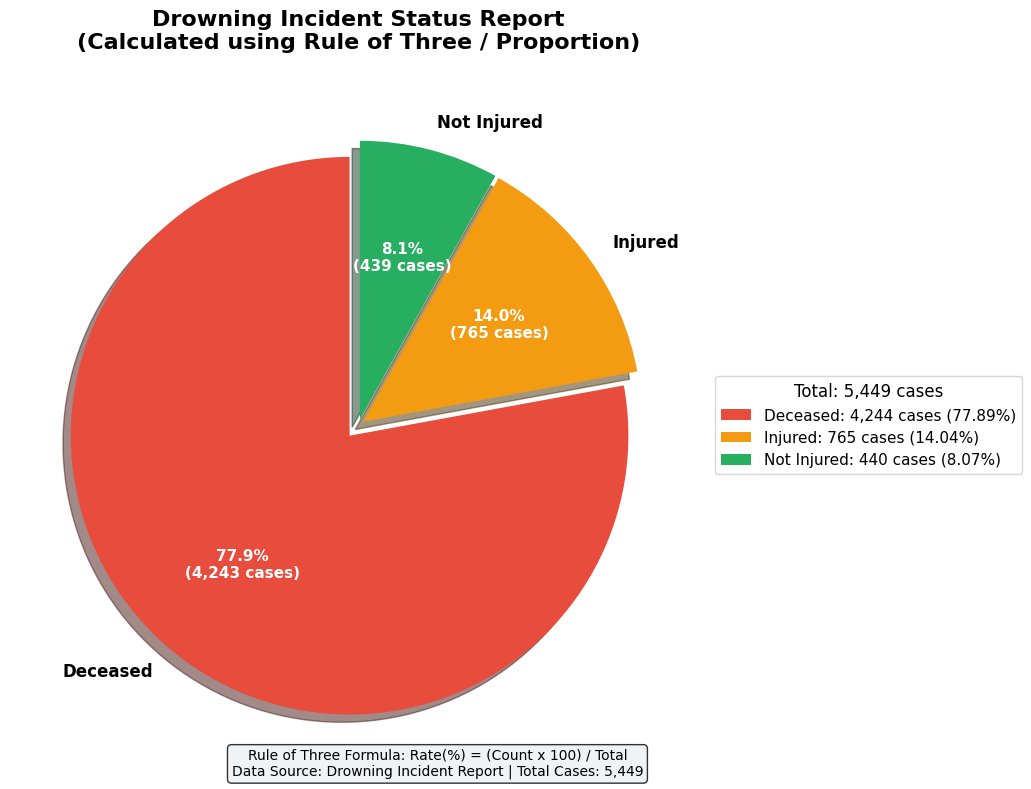

In [ ]:
"""
Script to create Pie Chart summarizing Drowning Status Data
- Deceased Rate / Injury Rate / No Injury Rate
- Calculated using Rule of Three (Proportion)
"""

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# Set font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Read Excel file
file_path = r"D:\Flooding\Drowning\Drowning_Report_สรุป.xlsx"  # Change path as needed
df = pd.read_excel(file_path)

# Count each status
status_counts = df['สถานะ'].value_counts()

# Get counts for each status
death_count = status_counts.get('เสียชีวิต', 0)
injured_count = status_counts.get('บาดเจ็บ', 0)
not_injured_count = status_counts.get('ไม่บาดเจ็บ', 0)

# Total count
total = death_count + injured_count + not_injured_count

# Calculate using Rule of Three (Proportion) - as percentage
# Formula: (Count x 100) / Total
death_rate = (death_count * 100) / total
injured_rate = (injured_count * 100) / total
not_injured_rate = (not_injured_count * 100) / total

# Display calculation results
print("=" * 70)
print("DROWNING STATUS SUMMARY REPORT")
print("=" * 70)
print(f"\nTotal Cases: {total:,}\n")
print("-" * 70)
print(f"{'Status':<20} {'Count':<15} {'Percentage':<15}")
print("-" * 70)
print(f"{'Deceased':<20} {death_count:>10,}     {death_rate:>10.2f}%")
print(f"{'Injured':<20} {injured_count:>10,}     {injured_rate:>10.2f}%")
print(f"{'Not Injured':<20} {not_injured_count:>10,}     {not_injured_rate:>10.2f}%")
print("-" * 70)
print(f"{'Total':<20} {total:>10,}     {100.00:>10.2f}%")
print("=" * 70)

# Rule of Three Calculation Display
print("\n" + "=" * 70)
print("RULE OF THREE CALCULATION (Proportion Method)")
print("=" * 70)
print(f"\nIf Total {total:,} cases = 100%")
print(f"Then:")
print(f"  - Deceased {death_count:,} cases = ({death_count} x 100) / {total} = {death_rate:.2f}%")
print(f"  - Injured {injured_count:,} cases = ({injured_count} x 100) / {total} = {injured_rate:.2f}%")
print(f"  - Not Injured {not_injured_count:,} cases = ({not_injured_count} x 100) / {total} = {not_injured_rate:.2f}%")

# Data for Pie Chart
labels = ['Deceased', 'Injured', 'Not Injured']
sizes = [death_rate, injured_rate, not_injured_rate]
counts = [death_count, injured_count, not_injured_count]
colors = ['#E74C3C', '#F39C12', '#27AE60']  # Red, Orange, Green
explode = (0.05, 0.02, 0.02)  # Emphasize deceased section

# Create Figure and Pie Chart
fig, ax = plt.subplots(figsize=(12, 8))

# Create Pie Chart
wedges, texts, autotexts = ax.pie(
    sizes, 
    explode=explode, 
    labels=labels, 
    colors=colors,
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*total):,} cases)',
    startangle=90,
    shadow=True,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

# Style the percentage text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

# Add Title
ax.set_title(
    'Drowning Incident Status Report\n'
    '(Calculated using Rule of Three / Proportion)',
    fontsize=16, 
    fontweight='bold',
    pad=20
)

# Add Legend with details
legend_labels = [
    f'Deceased: {death_count:,} cases ({death_rate:.2f}%)',
    f'Injured: {injured_count:,} cases ({injured_rate:.2f}%)',
    f'Not Injured: {not_injured_count:,} cases ({not_injured_rate:.2f}%)'
]
ax.legend(
    wedges, 
    legend_labels,
    title=f"Total: {total:,} cases",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=11,
    title_fontsize=12
)

# Add summary text at bottom
summary_text = (
    f"Rule of Three Formula: Rate(%) = (Count x 100) / Total\n"
    f"Data Source: Drowning Incident Report | Total Cases: {total:,}"
)
fig.text(0.5, 0.02, summary_text, ha='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='#ECF0F1', alpha=0.8))

plt.tight_layout()

# Save chart
output_path = 'drowning_status_pie_chart.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight', facecolor='white')
print(f"\nChart saved to: {output_path}")


### ความถี่

ข้อมูลความถี่
ปี         เกิดเหตุ        เสียชีวิต      
------------------------------------------------------------
2563       60              212            
2564       148             537            
2565       137             715            
2566       293             874            
2567       314             982            
2568       253             924            
------------------------------------------------------------
รวม        1205            4244           

บันทึก: histogram_frequency.png

สรุป
ความถี่ในการเกิดเหตุ (รอดชีวิต): 1,205 ราย (22.11%)
ความถี่ในการเสียชีวิต: 4,244 ราย (77.89%)
รวมทั้งหมด: 5,449 ราย


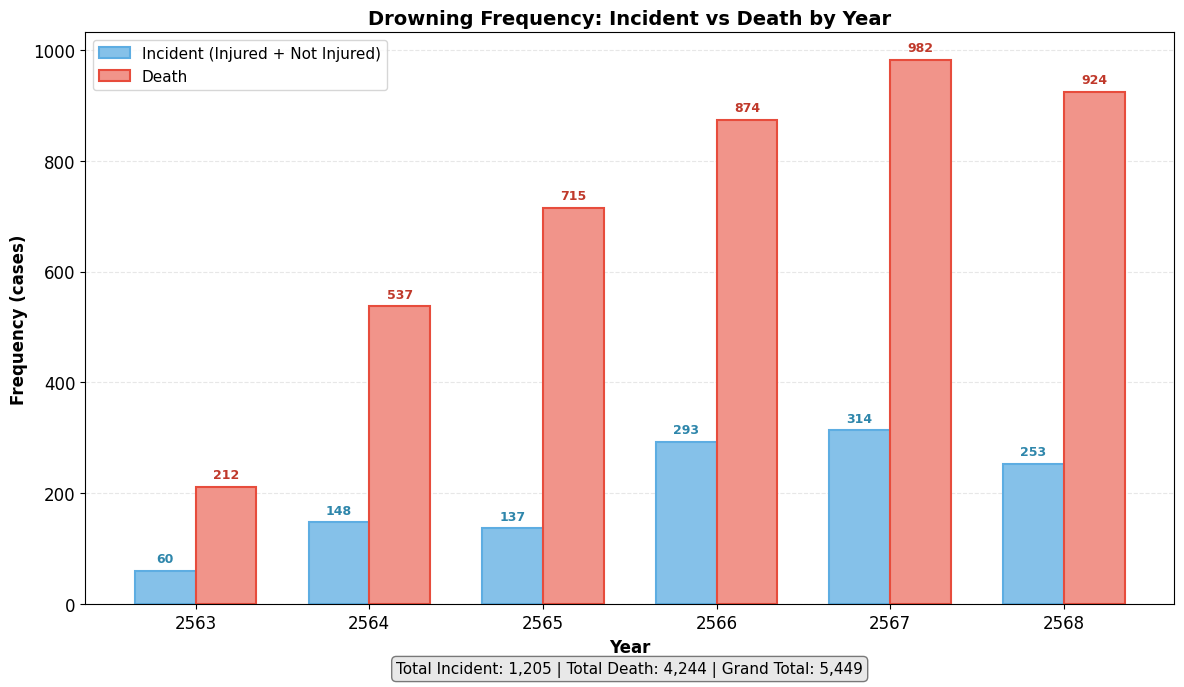

In [28]:
"""
สคริปต์สร้าง Histogram แสดงความถี่การเกิดเหตุ และความถี่ในการเสียชีวิต
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ตั้งค่า font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# อ่านไฟล์ Excel
file_path = "D:\Flooding\Drowning\Drowning_Report_สรุป.xlsx"
df = pd.read_excel(file_path)

# เตรียมข้อมูล
years = sorted(df['ปีที่เกิดเหตุ'].dropna().unique())
years = [int(y) for y in years]

# คำนวณความถี่ตามปี
incident_data = []  # เกิดเหตุ (บาดเจ็บ + ไม่บาดเจ็บ)
death_data = []     # เสียชีวิต

for year in years:
    year_df = df[df['ปีที่เกิดเหตุ'] == year]
    status = year_df['สถานะ'].value_counts()
    
    injured = status.get('บาดเจ็บ', 0)
    not_injured = status.get('ไม่บาดเจ็บ', 0)
    death = status.get('เสียชีวิต', 0)
    
    incident_data.append(injured + not_injured)
    death_data.append(death)

# คำนวณรวมทั้งหมด
total_incident = sum(incident_data)
total_death = sum(death_data)
total_all = total_incident + total_death

# แสดงข้อมูล
print("=" * 60)
print("ข้อมูลความถี่")
print("=" * 60)
print(f"{'ปี':<10} {'เกิดเหตุ':<15} {'เสียชีวิต':<15}")
print("-" * 60)
for i, year in enumerate(years):
    print(f"{year:<10} {incident_data[i]:<15} {death_data[i]:<15}")
print("-" * 60)
print(f"{'รวม':<10} {total_incident:<15} {total_death:<15}")
print("=" * 60)

# =============== สร้าง Histogram ===============
fig, ax = plt.subplots(figsize=(12, 7))

width = 0.35
x = np.arange(len(years))

bars1 = ax.bar(x - width/2, incident_data, width, label='Incident (Injured + Not Injured)', 
               color='#85C1E9', edgecolor='#5DADE2', linewidth=1.5)
bars2 = ax.bar(x + width/2, death_data, width, label='Death', 
               color='#F1948A', edgecolor='#E74C3C', linewidth=1.5)

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency (cases)', fontsize=12, fontweight='bold')
ax.set_title('Drowning Frequency: Incident vs Death by Year', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# เพิ่มตัวเลขบนแท่ง
for bar, val in zip(bars1, incident_data):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            f'{val}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='#2E86AB')

for bar, val in zip(bars2, death_data):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            f'{val}', ha='center', va='bottom', fontsize=9, fontweight='bold', color='#C0392B')

# เพิ่มข้อมูลสรุป
summary_text = f'Total Incident: {total_incident:,} | Total Death: {total_death:,} | Grand Total: {total_all:,}'
ax.text(0.5, -0.12, summary_text, transform=ax.transAxes, ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.savefig('histogram_frequency.png', dpi=150, bbox_inches='tight', facecolor='white')
print("\nบันทึก: histogram_frequency.png")

print("\n" + "=" * 60)
print("สรุป")
print("=" * 60)
print(f"ความถี่ในการเกิดเหตุ (รอดชีวิต): {total_incident:,} ราย ({total_incident/total_all*100:.2f}%)")
print(f"ความถี่ในการเสียชีวิต: {total_death:,} ราย ({total_death/total_all*100:.2f}%)")
print(f"รวมทั้งหมด: {total_all:,} ราย")

### เหตุการณ์ซ้ำ

In [4]:
import pandas as pd

# ===============================
# PATH ไฟล์
# ===============================
file_path = r"D:\Flooding\Drowning\Drowning_Report_สรุป.xlsx"

# ===============================
# READ EXCEL
# ===============================
df = pd.read_excel(file_path)

# ===============================
# REQUIRED COLUMNS
# ===============================
required_cols = [
    "ID เหตุการณ์",
    "จังหวัดที่เกิดเหตุ",
    "อำเภอที่เกิดเหตุ",
    "ตำบลที่เกิดเหตุ",
    "เพศ",
    "อายุ (ปี)",
    "อายุ (เดือน)",
    "ขณะเกิดเหตุ (ณ จุดเกิดเหตุ) คนที่จมน้ำอยู่กับใคร"
]

missing_cols = [c for c in required_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"ไม่พบคอลัมน์ต่อไปนี้ในไฟล์ Excel: {missing_cols}")

# ===============================
# GROUP & COUNT
# ===============================
summary_df = (
    df
    .groupby([
        "ID เหตุการณ์",
        "จังหวัดที่เกิดเหตุ",
        "อำเภอที่เกิดเหตุ",
        "ตำบลที่เกิดเหตุ",
        "เพศ",
        "อายุ (ปี)",
        "อายุ (เดือน)",
        "ขณะเกิดเหตุ (ณ จุดเกิดเหตุ) คนที่จมน้ำอยู่กับใคร"
    ])
    .size()
    .reset_index(name="จำนวนครั้งที่ซ้ำ")
    .sort_values("จำนวนครั้งที่ซ้ำ", ascending=False)
)

# ===============================
# SHOW RESULT
# ===============================
print(summary_df)

# ===============================
# EXPORT RESULT
# ===============================
output_path = r"D:\Flooding\Drowning\Drowning_ID_Summary.xlsx"
summary_df.to_excel(output_path, index=False)

print(f"\nบันทึกไฟล์สรุปเรียบร้อย:\n{output_path}")


      ID เหตุการณ์ จังหวัดที่เกิดเหตุ อำเภอที่เกิดเหตุ ตำบลที่เกิดเหตุ   เพศ  \
1920          2435             สกลนคร        กุสุมาลย์       กุสุมาลย์   ชาย   
2315          2855          มหาสารคาม          นาเชือก         นาเชือก   ชาย   
536            769             สกลนคร           พังโคน             แร่  หญิง   
2283          2820             นครพนม      เมืองนครพนม         ขามเฒ่า   ชาย   
3519          4266             สกลนคร      เมืองสกลนคร      เชียงเครือ   ชาย   
...            ...                ...              ...             ...   ...   
5126          6100    พระนครศรีอยุธยา             เสนา         บ้านแถว   ชาย   
5127          6101             ภูเก็ต             ถลาง         ป่าคลอก   ชาย   
5128          6102      นครศรีธรรมราช          พระพรหม       ท้ายสำเภา   ชาย   
5129          6104        อุบลราชธานี    พิบูลมังสาหาร          ดอนจิก   ชาย   
9               46          บุรีรัมย์             ปะคำ            ปะคำ   ชาย   

      อายุ (ปี)  อายุ (เดือน)  \
1920  

### รวมข้อมูลประชากร

In [16]:
import pandas as pd
import glob
import os

# --- 1. ตั้งค่า Path (แก้ไขที่อยู่โฟลเดอร์ที่นี่) ---
pop_folder = r'D:\Flooding\Drowning\pop'
drowning_file = r'D:\Flooding\Drowning\Drowning_Report_สรุป.csv'
output_file = r'D:\Flooding\Drowning\Drowning_Report_Merged.csv'

def merge_population_data():
    print("--- เริ่มการประมวลผล ---")
    
    # อ่านไฟล์หลัก (Drowning Report)
    if not os.path.exists(drowning_file):
        print(f"❌ ไม่พบไฟล์หลักที่: {drowning_file}")
        return
    
    # อ่านไฟล์ CSV หลัก (ใช้ utf-8-sig เพื่อรองรับภาษาไทย)
    df_main = pd.read_csv(drowning_file, encoding='utf-8-sig')
    
    # เตรียม Key สำหรับแมช (แปลง Local_code เป็น string 6 หลัก)
    df_main['ปีที่เกิดเหตุ'] = df_main['ปีที่เกิดเหตุ'].astype(str).str.strip()
    df_main['merge_key'] = df_main['Local_code'].fillna(0).astype(int).astype(str).str.strip()

    # รายการไฟล์ประชากร
    stat_files = glob.glob(os.path.join(pop_folder, 'stat_*.csv'))
    all_pop_list = []

    print(f"พบไฟล์ stat ทั้งหมด {len(stat_files)} ไฟล์")

    for f in stat_files:
        try:
            # อ่านไฟล์ stat
            df_stat = pd.read_csv(f, encoding='utf-8-sig')
            
            # 1. จัดการเรื่องปี (6312 -> 2563)
            # ตัด 2 หลักแรกมาบวก 2500
            df_stat['ปีที่เกิดเหตุ'] = '25' + df_stat['ปีเดือน'].astype(str).str.zfill(4).str[:2]
            
            # 2. จัดการรหัสตำบล (8 หลัก -> 6 หลัก)
            # เช่น 81011700 -> 810117
            df_stat['merge_key'] = (pd.to_numeric(df_stat['รหัสตำบล'], errors='coerce').fillna(0).astype(int) // 100).astype(str)
            
            # 3. จัดการตัวเลขประชากร (ลบคอมมา และแปลงเป็นตัวเลข)
            pop_cols = ['จำนวนประชากรชาย', 'จำนวนประชากรหญิง', 'จำนวนประชากรทั้งหมด']
            for col in pop_cols:
                if col in df_stat.columns:
                    df_stat[col] = df_stat[col].astype(str).str.replace(',', '').str.strip()
                    df_stat[col] = pd.to_numeric(df_stat[col], errors='coerce').fillna(0).astype(int)

            # 4. กรองเอาเฉพาะระดับตำบล (รหัสหมู่บ้านต้องเป็น 0 และรหัสตำบลต้องไม่เป็น 0)
            df_tambon = df_stat[(df_stat['รหัสหมู่บ้าน'] == 0) & (df_stat['รหัสตำบล'] != 0)].copy()
            
            # เลือกเฉพาะคอลัมน์ที่จำเป็น
            df_tambon = df_tambon[['merge_key', 'ปีที่เกิดเหตุ'] + pop_cols]
            all_pop_list.append(df_tambon)
            print(f"✅ ประมวลผลไฟล์ {os.path.basename(f)} สำเร็จ")
            
        except Exception as e:
            print(f"❌ เกิดข้อผิดพลาดที่ไฟล์ {os.path.basename(f)}: {e}")

    if not all_pop_list:
        print("ไม่พบข้อมูลประชากรที่จะนำมารวม")
        return

    # รวมข้อมูลประชากรทุกปีเข้าด้วยกัน และลบข้อมูลซ้ำ (กรณีมีหลายเดือน ให้เอาเดือนล่าสุด)
    df_all_pop = pd.concat(all_pop_list, ignore_index=True)
    df_all_pop = df_all_pop.drop_duplicates(subset=['merge_key', 'ปีที่เกิดเหตุ'], keep='last')

    # --- 5. นำข้อมูลมาต่อกัน (Merge) ---
    df_final = pd.merge(
        df_main,
        df_all_pop,
        on=['merge_key', 'ปีที่เกิดเหตุ'],
        how='left'
    )

    # ลบคอลัมน์ที่ใช้เป็น Key ออก
    df_final = df_final.drop(columns=['merge_key'])

    # บันทึกเป็นไฟล์ CSV
    df_final.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"\n✨ เสร็จสมบูรณ์! บันทึกไฟล์ที่: {output_file}")

if __name__ == "__main__":
    merge_population_data()

--- เริ่มการประมวลผล ---
พบไฟล์ stat ทั้งหมด 5 ไฟล์
✅ ประมวลผลไฟล์ stat_63.csv สำเร็จ
✅ ประมวลผลไฟล์ stat_64.csv สำเร็จ
✅ ประมวลผลไฟล์ stat_65.csv สำเร็จ
✅ ประมวลผลไฟล์ stat_66.csv สำเร็จ
✅ ประมวลผลไฟล์ stat_67.csv สำเร็จ

✨ เสร็จสมบูรณ์! บันทึกไฟล์ที่: D:\Flooding\Drowning\Drowning_Report_Merged.csv


### คำนวน

จำนวนแถวข้อมูลหลัง Join: 5478 แถว
บันทึกไฟล์เรียบร้อยที่: D:\Flooding\Drowning\Drowning_Graduated_Map.geojson


c:\Users\GISDA\.conda\envs\geo_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=16.
  warnings.warn(


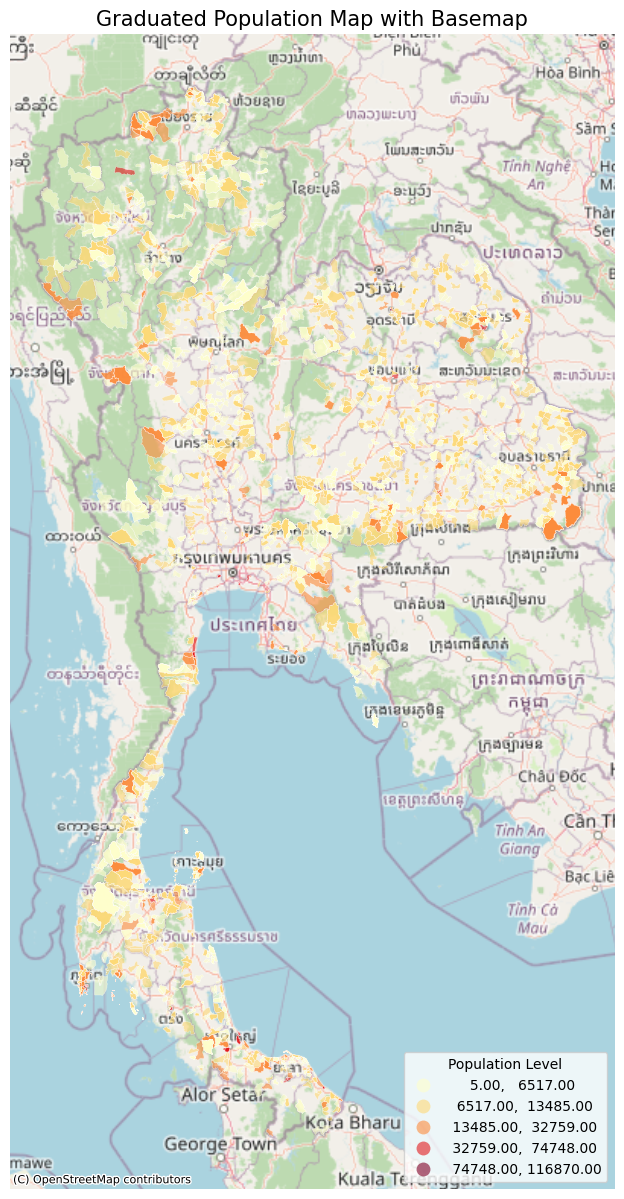

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# 1. โหลดข้อมูล
csv_path = r"D:\Flooding\Drowning\Drowning_Report_Merged.csv"
shp_path = r"D:\Flooding\Drowning\case.shp"

df = pd.read_csv(csv_path)
gdf_map = gpd.read_file(shp_path)

# เช็คและกำหนด CRS เริ่มต้นหากไฟล์ shp ไม่มีข้อมูลพิกัด
if gdf_map.crs is None:
    gdf_map.set_crs(epsg=4326, inplace=True)

# 2. จัดการ Data Type ให้ตรงกัน
gdf_map['TAMBON_IDN'] = gdf_map['TAMBON_IDN'].astype(str).str.strip()
df['Local_code'] = df['Local_code'].astype(str).str.split('.').str[0].str.strip()

# 3. Join ข้อมูล
merged_gdf = gdf_map.merge(df, left_on='TAMBON_IDN', right_on='Local_code')

# ตรวจสอบว่า Join ติดหรือไม่
print(f"จำนวนแถวข้อมูลหลัง Join: {len(merged_gdf)} แถว")

if len(merged_gdf) > 0:
    # 4. บันทึกไฟล์เป็น GeoJSON
    output_geojson = r"D:\Flooding\Drowning\Drowning_Graduated_Map.geojson"
    merged_gdf.to_file(output_geojson, driver='GeoJSON')
    print(f"บันทึกไฟล์เรียบร้อยที่: {output_geojson}")

    # 5. เตรียมทำแผนที่ (แปลงเป็น Web Mercator เพื่อใช้กับ Basemap)
    merged_gdf_3857 = merged_gdf.to_crs(epsg=3857)

    # 6. สร้างแผนที่แบบ Graduated
    fig, ax = plt.subplots(figsize=(12, 15))

    # พล็อตข้อมูลแบบ Choropleth
    merged_gdf_3857.plot(
        column='จำนวนประชากรทั้งหมด', 
        ax=ax, 
        cmap='YlOrRd', 
        legend=True, 
        scheme='NaturalBreaks',  # ต้องมี mapclassify ถึงจะใช้งานส่วนนี้ได้
        k=5,                     
        alpha=0.6,               
        edgecolor='white', 
        linewidth=0.3,
        legend_kwds={'title': "Population Level", 'loc': 'lower right'}
    )

    # 7. ใส่ Basemap
    try:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    except Exception as e:
        print(f"ไม่สามารถใส่ Basemap ได้เนื่องจาก: {e}")

    ax.set_title('Graduated Population Map with Basemap', fontsize=15)
    ax.set_axis_off()
    plt.show()
else:
    print("Error: ไม่สามารถสร้างแผนที่ได้ เนื่องจาก Join ข้อมูลไม่สำเร็จ (0 แถว)")